<a href="https://colab.research.google.com/github/YamanShqeirat/sahde-ml/blob/main/ShadeML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Environment Setup & Data Organization

### 0.1 Environment & Library versions (Colab)

In [1]:
# Colab environemnt set up
!pip -q install pandas pyarrow fastparquet geopandas shapely rasterio scikit-learn matplotlib seaborn

import os, sys, json, textwrap, zipfile, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import geopandas as gpd
import rasterio

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

print("Python version:", sys.version)
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Scikit-learn:", sklearn.__version__)
print("GeoPandas:", gpd.__version__)
print("Rasterio:", rasterio.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.4 MB/s eta 0:00:00
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas: 2.2.2
Numpy: 2.0.2
Scikit-learn: 1.6.1
GeoPandas: 1.1.1
Rasterio: 1.4.3


### 0.2 Mount Google Drive and set up project directories

In [2]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/CSE475 - Final Project"

RANDOM_STATE = 42

# Standard subfolders
RAW_DIR     = os.path.join(PROJECT_ROOT, "Datasets")        # raw uploads
INTERIM_DIR = os.path.join(PROJECT_ROOT, "interim")         # cleaned/intermediate
REPORTS_DIR = os.path.join(PROJECT_ROOT, "reports_figures") # charts/tables

for p in [INTERIM_DIR, REPORTS_DIR]:
    os.makedirs(p, exist_ok=True)

print("\nProject root:", PROJECT_ROOT)
print("\nRAW_DIR:", RAW_DIR)
print("\nINTERIM_DIR:", INTERIM_DIR)
print("\nREPORTS_DIR:", REPORTS_DIR)


Mounted at /content/drive

Project root: /content/drive/MyDrive/CSE475 - Final Project

RAW_DIR: /content/drive/MyDrive/CSE475 - Final Project/Datasets

INTERIM_DIR: /content/drive/MyDrive/CSE475 - Final Project/interim

REPORTS_DIR: /content/drive/MyDrive/CSE475 - Final Project/reports_figures


### 1.1 Inspect available raw datasets

In [3]:
from pathlib import Path
from collections import Counter

def walk_dir(d, exts=None):
    d = Path(d)
    for p in sorted(d.rglob("*")):
        if p.is_file():
            if exts is None or p.suffix.lower() in exts:
                size_mb = p.stat().st_size / (1024*1024)
                print(f"{p.relative_to(d)}  [{size_mb:,.2f} MB]")

# When no files are found
files = list(Path(RAW_DIR).rglob("*"))

ext_counts = Counter([p.suffix.lower() for p in files if p.is_file()])

if not files:
    print("No files found in RAW_DIR!")

# When files are found
print(f"Found {len(files)} files total.")
print("\n== RAW ==")
walk_dir(RAW_DIR, exts={".csv", ".zip", ".tif", ".geojson", ".parquet", ".xlsx"})
print("\nFile type counts:", ext_counts)


Found 6 files total.

== RAW ==
647_IET_measurements_50e72be656c7407bd07e316061beeb1d.csv  [0.10 MB]
All_LC_Sensor_Climate.csv  [34.10 MB]
GlobalLandTemperaturesByCity.csv  [508.15 MB]
HLS.L30.T12SVB.2024209T175727.v2.0.Fmask.tif  [1.50 MB]
LULC_temp_prediction.csv  [83.00 MB]
Where_Will_Tree_Planting_Improve_Urban_Heat_Health%3F.csv  [113.03 MB]

File type counts: Counter({'.csv': 5, '.tif': 1})


### 1.2 Load & validate core datasets (Kaggle GLT, CAP LTER IET)

In [4]:
# Confirming data integrity of main CSV files
from pathlib import Path
import pandas as pd

# --- Kaggle: Global Land Temperatures by City ---
kaggle_path = Path(RAW_DIR) / "GlobalLandTemperaturesByCity.csv"
if not kaggle_path.exists():
    folder_alt = Path(RAW_DIR) / "GlobalLandTemperaturesByCity"
    candidates = list(folder_alt.rglob("*.csv")) if folder_alt.exists() else []
    if candidates:
        kaggle_path = candidates[0]

print(f" Kaggle dataset path: {kaggle_path}")
temps_city = pd.read_csv(kaggle_path)
print(f" Loaded Kaggle temperature data: {temps_city.shape[0]:,} rows × {temps_city.shape[1]} columns")
display(temps_city.head(3))

# --- CAP LTER: IET Measurements ---
iet_candidates = sorted(Path(RAW_DIR).rglob("*IET*measurements*.csv"))
assert len(iet_candidates) >= 1, " IET measurements CSV not found in RAW_DIR"
iet_path = iet_candidates[0]

print(f"\n CAP LTER dataset path: {iet_path}")
iet = pd.read_csv(iet_path)
print(f" Loaded CAP LTER IET data: {iet.shape[0]:,} rows × {iet.shape[1]} columns")
display(iet.head(3))


 Kaggle dataset path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/GlobalLandTemperaturesByCity.csv
 Loaded Kaggle temperature data: 8,599,212 rows × 7 columns


dt  AverageTemperature  AverageTemperatureUncertainty   City  Country Latitude Longitude
0  1743-11-01               6.068                          1.737  Århus  Denmark   57.05N    10.33E
1  1743-12-01                 NaN                            NaN  Århus  Denmark   57.05N    10.33E
2  1744-01-01                 NaN                            NaN  Århus  Denmark   57.05N    10.33E


 CAP LTER dataset path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/647_IET_measurements_50e72be656c7407bd07e316061beeb1d.csv
 Loaded CAP LTER IET data: 3,360 rows × 3 columns


Subject ID         period  temperature
0         1A  Sat, 8pm-12am    25.144467
1         1P  Sat, 8pm-12am    26.779625
2         1E  Sat, 8pm-12am    27.218750

In [5]:
print("\n=== Loading Additional Raw Datasets ===\n")

from pathlib import Path
import pandas as pd
import rasterio

# 1) All_LC_Sensor_Climate.csv
lc_climate_candidates = list(Path(RAW_DIR).rglob("All_LC_Sensor_Climate*.csv"))
if lc_climate_candidates:
    lc_climate_path = lc_climate_candidates[0]
    print(" LC Sensor Climate path:", lc_climate_path)
    lc_climate = pd.read_csv(lc_climate_path)
    print(f" Loaded LC climate data: {lc_climate.shape[0]:,} rows × {lc_climate.shape[1]} columns")
    display(lc_climate.head(3))
else:
    print(" LC Sensor Climate dataset not found.")

# 2) LULC_temp_prediction.csv
lulc_candidates = list(Path(RAW_DIR).rglob("LULC_temp_prediction*.csv"))
if lulc_candidates:
    lulc_path = lulc_candidates[0]
    print("\n LULC prediction path:", lulc_path)
    lulc = pd.read_csv(lulc_path)
    print(f" Loaded LULC prediction data: {lulc.shape[0]:,} rows × {lulc.shape[1]} columns")
    display(lulc.head(3))
else:
    print(" LULC prediction dataset not found.")

# 3) Tree-planting / Heat-Health dataset
tree_candidates = list(Path(RAW_DIR).rglob("Where_Will_Tree_Planting*"))
if tree_candidates:
    tree_path = tree_candidates[0]
    print("\n Tree planting path:", tree_path)
    tree_df = pd.read_csv(tree_path)
    print(f" Loaded tree planting dataset: {tree_df.shape[0]:,} rows × {tree_df.shape[1]} columns")
    display(tree_df.head(3))
else:
    print(" Tree planting dataset not found.")

# 4) HLS Fmask raster (cloud/shade mask)
hls_candidates = list(Path(RAW_DIR).rglob("*.tif"))
if hls_candidates:
    hls_path = hls_candidates[0]
    print("\n HLS TIF path:", hls_path)
    with rasterio.open(hls_path) as src:
        print(" Raster CRS:", src.crs)
        print(" Raster size:", src.width, "x", src.height)
        print(" Raster bands:", src.count)
else:
    print(" No .tif files found for HLS.")



=== Loading Additional Raw Datasets ===

 LC Sensor Climate path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/All_LC_Sensor_Climate.csv
 Loaded LC climate data: 259,244 rows × 16 columns


Date   Hour ibuttonID       Lat        Lon  Impervious Surface  Turf/Grass  Tree Canopy  Buildings  Regional Air Temperature  Regional Relative Humidity  \
0  6/11/2018  13:00       M04  36.16523 -115.10812            0.259719    0.377171     0.328371   0.034739                 36.666667                         6.0   
1  6/11/2018  13:00      VH09  36.23288 -115.21085            0.000000    0.816529     0.183471   0.000000                 36.666667                         6.0   
2  6/11/2018  13:00       H03  36.13335 -115.30010            0.486352    0.031431     0.482217   0.000000                 36.666667                         6.0   

   Regional Wind Speed  Mean Landsat Land Surface Temperature  Sensor Recorded Air Temperature       City     Diel  
0                  0.0                              48.563597                             38.0  Las Vegas  Daytime  
1                  0.0                              42.936060                             36.5  Las Vegas  Daytime  
2                  0.0                              46.000578                             35.5  Las Vegas  Daytime


 LULC prediction path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/LULC_temp_prediction.csv
 Loaded LULC prediction data: 693,932 rows × 14 columns


City   Latitude  Longitude  Impervious     Grass      Tree  Building      LST  Tair_pred25_75  Tair_pred95  Tair_pred25_75_nt  Tair_pred95_nt  Tair_diff_day  Tair_diff_nt
0  Baltimore  39.372907 -76.532530    0.028056  0.203889  0.701389  0.066667  28.1021       27.721166    32.160609          22.371962       24.869003       4.439443      2.497041
1  Baltimore  39.372639 -76.552723    0.146389  0.393611  0.255556  0.204444  31.6356       28.450265    32.318988          21.889037       24.748836       3.868723      2.859799
2  Baltimore  39.372630 -76.553420    0.371389  0.223056  0.227778  0.177778  31.9305       29.631663    33.329234          22.348018       25.723821       3.697571      3.375803


 Tree planting path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/Where_Will_Tree_Planting_Improve_Urban_Heat_Health%3F.csv
 Loaded tree planting dataset: 72,246 rows × 194 columns


OBJECTID        GEOID               NAME  State          County      ALAND     AWATER  B01001_001E  B01001_calc_pctGE65E  B01001_calc_pctGE65E_BOX_COX  \
0         1  48007950100  Census Tract 9501  Texas  Aransas County  474836653  467090161         5333                  39.2                     10.998628   
1         2  48007950200  Census Tract 9502  Texas  Aransas County    2685464   17605331         1085                  42.8                     11.601322   
2         3  48007950300  Census Tract 9503  Texas  Aransas County   16782890      33834         7598                  27.6                      8.847904   

   B03002_calc_pctNHWhiteE  PCT_Pop_Minority  B01001_003E  B01001_027E  Total_Young_People  PCT_Young_People  B17020_calc_pctPovE  B25002_calc_pctVacE  B15002_calc_pctLTHSE  \
0                     80.1              19.9           72          214                 286          5.362835                 13.0                 48.8                  10.9   
1                     84.3              15.7           33           33                  66          6.082949                  2.9                 62.0                   0.4   
2                     56.9              43.1          270          120                 390          5.132930                 24.9                 25.0                  17.6   

   B08201_calc_pctNoVehE  B08201_calc_pctNoVehE_BOX_COX  B28002_calc_pctNoIntE  B18101_calc_pctDE  PCT_HH_Lives_Alone  B16004_calc_pctGE18LEAE  B01001_calc_pctDependE  \
0                    1.9                       0.701909                   15.6               20.8                35.2                      3.8                    52.6   
1                    3.1                       1.326916                   10.2               12.8                41.6                      0.5                    53.1   
2                    3.2                       1.370426                    8.7               16.1                29.4                     14.1                    43.4   

   PCT_HU_Built_Prior_1970  B25002_001E  B25002_calc_pctTotalOwnE  B25002_calc_pctTotalRentE  Mean_Annual_Est_PM2_5_μg_m3  CASTHMA_CrudePrev   Area_SqKm  Pop_Density_PPL_SqKm  \
0                     14.4         4713                      41.5                        9.7                     7.142283                8.5  482.785150                    11   
1                     14.5         1595                      28.3                        9.7                     7.201200                7.3    2.790051                   389   
2                     28.1         3775                      57.4                       17.7                     7.234884                9.2   16.816716                   452   

   Pop_Density_PPL_SqKm_BOX_COX  High_Summer_Mean_LST_F  PCT_TreeCanopy  PCT_TreeCanopy_BOX_COX  PCT_LackingCanopy  PCT_ImperviousSurfaces  WF_HousingDensity_MEAN  \
0                      2.959684               99.245789        9.034360                3.051622          90.965640                1.590426                8.028874   
1                     10.323019               94.477371        1.186391                0.175108          98.813609               51.151642              247.281481   
2                     10.741555               95.835266        8.732339                2.988628          91.267661               27.330107              302.815288   

   WF_HousingDensity_MEAN_BOX_COX  WF_Exp_Type_MEAN  WF_RiskToHome_Mean  WF_RiskToHome_Mean_BOX_COX  WF_HazardPotential_Mean  WF_HazardPotential_Mean_BOX_COX  Cnt_Rd_Inter  \
0                        2.454300          0.807294            0.011670                   -4.158151                58.122018                         5.623419            74   
1                        8.661517          0.120160            0.000297                   -7.181550                 2.931635                         1.168629            40   
2                        9.140689          0.479790            0.003955              


 HLS TIF path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/HLS.L30.T12SVB.2024209T175727.v2.0.Fmask.tif
 Raster CRS: EPSG:32612
 Raster size: 3660 x 3660
 Raster bands: 1


### 1.3 Inspect schema and normalize column names

In [6]:
# What columns do I have, and what do they look like?

# Are the column names consistent and easy to work with?

# Are dates properly formatted (as datetimes, not strings)?

def peek(df, name, n=3):
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    display(df.sample(min(n, len(df))).head(n))
    print(df.dtypes.head(20))

peek(temps_city, "GlobalLandTemperaturesByCity")
peek(iet, "CAP-LTER IET measurements")

def clean_cols(df):
    return df.rename(columns={c: c.strip().lower().replace(" ", "_") for c in df.columns})

# ---- Standardize column names for all datasets (where available) ----

datasets = {
    "temps_city": temps_city,
    "iet": iet,
    "lc_climate": lc_climate if 'lc_climate' in globals() else None,
    "lulc": lulc if 'lulc' in globals() else None,
    "tree_df": tree_df if 'tree_df' in globals() else None
}

for name, df in datasets.items():
    if df is None:
        print(f"\n{name}: Not loaded, skipping.")
        continue
    print(f"\nCleaning column names for {name} ...")
    df = clean_cols(df)
    datasets[name] = df  # update reference

temps_city = datasets["temps_city"]
iet        = datasets["iet"]

if "lc_climate" in datasets: lc_climate = datasets["lc_climate"]
if "lulc" in datasets: lulc = datasets["lulc"]
if "tree_df" in datasets: tree_df = datasets["tree_df"]

possible_date_cols = ["dt", "date", "time", "timestamp", "day"]

for name, df in datasets.items():
    if df is None:
        continue
    print(f"\nParsing date columns in {name} ...")
    for col in df.columns:
        if any(key in col for key in possible_date_cols):
            try:
                df[col] = pd.to_datetime(df[col], errors="ignore")
            except:
                pass

print("\n=== Schema inspection for ALL datasets ===")
for name, df in datasets.items():
    if df is not None:
        peek(df, name)



=== GlobalLandTemperaturesByCity ===
Shape: (8599212, 7)


dt  AverageTemperature  AverageTemperatureUncertainty         City        Country Latitude Longitude
806943   1839-08-01              25.908                          1.668      Bellary          India   15.27N    77.50E
7148592  2007-11-01               2.761                          0.237  Springfield  United States   42.59N    72.00W
2587533  1867-04-01               1.336                          2.153       Glazov         Russia   58.66N    52.31E

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

=== CAP-LTER IET measurements ===
Shape: (3360, 3)


Subject ID         period  temperature
3087         3J   Sat, 4am-8am    25.281188
737          2T  Mon, 8am-12pm    30.364625
2472         3F  Thu, 8pm-12am    27.205625

Subject ID      object
period          object
temperature    float64
dtype: object

Cleaning column names for temps_city ...

Cleaning column names for iet ...

Cleaning column names for lc_climate ...

Cleaning column names for lulc ...

Cleaning column names for tree_df ...

Parsing date columns in temps_city ...

Parsing date columns in iet ...

Parsing date columns in lc_climate ...

Parsing date columns in lulc ...

Parsing date columns in tree_df ...

=== Schema inspection for ALL datasets ===

=== temps_city ===
Shape: (8599212, 7)


dt  averagetemperature  averagetemperatureuncertainty      city  country latitude longitude
5475587 1921-04-01              27.679                          0.531   Onitsha  Nigeria    5.63N     6.46E
7874265 1838-06-01              12.396                          1.027  Ulan Ude   Russia   52.24N   107.74E
2245640 1849-06-01              17.989                          1.494  Erzincan   Turkey   39.38N    39.54E

dt                               datetime64[ns]
averagetemperature                      float64
averagetemperatureuncertainty           float64
city                                     object
country                                  object
latitude                                 object
longitude                                object
dtype: object

=== iet ===
Shape: (3360, 3)


subject_id         period  temperature
804         2N  Mon, 12pm-4pm    28.770813
852         4D  Mon, 12pm-4pm    30.020937
102         2R  Sun, 12am-4am    24.542875

subject_id      object
period          object
temperature    float64
dtype: object

=== lc_climate ===
Shape: (259244, 16)


date  hour ibuttonid        lat         lon  impervious_surface  turf/grass  tree_canopy  buildings  regional_air_temperature  regional_relative_humidity  \
142759  8/8/2018  1:00       L05  36.131570 -115.115140            0.674092    0.000000     0.173267   0.152640                 33.888889                   16.000000   
169668  19-08-04  3:00   H02_212  32.299130 -111.000030            0.176587    0.339448     0.142141   0.212617                 27.777778                   47.000000   
251577  8/4/2018  2:00   L18_106  25.834454  -80.280529            0.518414    0.072238     0.171388   0.228045                 25.925926                   83.666667   

        regional_wind_speed  mean_landsat_land_surface_temperature  sensor_recorded_air_temperature       city       diel  
142759             7.000000                              50.378206                             34.1  Las Vegas  Nighttime  
169668             7.000000                              49.252859                             28.5     Tucson  Nighttime  
251577             3.666667                              38.766667                             24.6      Miami  Nighttime

date                                      object
hour                                      object
ibuttonid                                 object
lat                                      float64
lon                                      float64
impervious_surface                       float64
turf/grass                               float64
tree_canopy                              float64
buildings                                float64
regional_air_temperature                 float64
regional_relative_humidity               float64
regional_wind_speed                      float64
mean_landsat_land_surface_temperature    float64
sensor_recorded_air_temperature          float64
city                                      object
diel                                      object
dtype: object

=== lulc ===
Shape: (693932, 14)


city   latitude   longitude  impervious     grass      tree  building        lst  tair_pred25_75  tair_pred95  tair_pred25_75_nt  tair_pred95_nt  \
587834  Portland  25.721159  -80.283348    0.077148  0.200195  0.607422  0.115234  37.395303       29.371737    32.943798          25.453947       25.730429   
485508   Phoenix  33.390451 -111.836904    0.000000  0.024722  0.007222  0.370556  53.552600       40.953884    45.416985          30.406310       34.266821   
625676    Tucson  32.245766 -110.942331    0.209338  0.000000  0.529478  0.129870  48.128900       41.141625    44.692336          27.046653       31.083114   

                       tair_diff_day  tair_diff_nt  
587834 1970-01-01 00:00:00.000000003      0.276482  
485508 1970-01-01 00:00:00.000000004      3.860511  
625676 1970-01-01 00:00:00.000000003      4.036461

city                         object
latitude                    float64
longitude                   float64
impervious                  float64
grass                       float64
tree                        float64
building                    float64
lst                         float64
tair_pred25_75              float64
tair_pred95                 float64
tair_pred25_75_nt           float64
tair_pred95_nt              float64
tair_diff_day        datetime64[ns]
tair_diff_nt                float64
dtype: object

=== tree_df ===
Shape: (72246, 194)


objectid        geoid               name     state         county    aland  awater  b01001_001e  b01001_calc_pctge65e  b01001_calc_pctge65e_box_cox  \
57315     57316  17031170900  Census Tract 1709  Illinois    Cook County   320577       0         1943                  15.1                      5.953345   
18246     18247  36081115100  Census Tract 1151  New York  Queens County   282637   13939          915                  31.4                      9.593506   
65691     65692  39085206600  Census Tract 2066      Ohio    Lake County  2637244       0         4815                  16.9                      6.427411   

       b03002_calc_pctnhwhitee  pct_pop_minority  b01001_003e  b01001_027e  total_young_people  pct_young_people  b17020_calc_pctpove  b25002_calc_pctvace  b15002_calc_pctlthse  \
57315                     49.8              50.2           34           48                  82          4.220278                 10.4                  5.1                  17.8   
18246                     49.3              50.7           13           26                  39          4.262295                  1.1                 13.1                  18.1   
65691                     88.1              11.9          131           26                 157          3.260644                 16.1                  3.6                   7.0   

       b08201_calc_pctnovehe  b08201_calc_pctnovehe_box_cox  b28002_calc_pctnointe  b18101_calc_pctde  pct_hh_lives_alone  b16004_calc_pctge18leae  b01001_calc_pctdepende  \
57315                    6.6                       2.472801                   23.0                8.0                22.0                     29.7                    38.2   
18246                   18.9                       4.521203                   21.8               13.6                19.8                     31.4                    43.7   
65691                    5.2                       2.085289                   12.3               13.9                31.6                      4.2                    40.0   

       pct_hu_built_prior_1970  b25002_001e  b25002_calc_pcttotalowne  b25002_calc_pcttotalrente  mean_annual_est_pm2_5_μg_m3  casthma_crudeprev  area_sqkm  pop_density_ppl_sqkm  \
57315                     77.8          686                      61.8                       33.1                     9.917739                9.1   0.320577                  6061   
18246                     98.2          396                      76.0                       10.9                     8.070365                7.8   0.296576                  3085   
65691                     84.2         2105                      71.3                       25.2                     9.096979               10.3   2.637167                  1826   

       pop_density_ppl_sqkm_box_cox  high_summer_mean_lst_f  pct_treecanopy  pct_treecanopy_box_cox  pct_lackingcanopy  pct_impervioussurfaces  wf_housingdensity_mean  \
57315                     19.954439               99.885262        5.200000                2.099511          94.800000               64.729577             2590.416201   
18246                     17.154433               97.927368       21.657576                4.897704          78.342424               49.240122             1622.878788   
65691                     15.191089               90.624741       20.629983                4.782670          79.370017               38.791070              846.134333   

       wf_housingdensity_mean_box_cox  wf_exp_type_mean  wf_risktohome_mean  wf_risktohome_mean_box_cox  wf_hazardpotential_mean  wf_hazardpotential_mean_box_cox  cnt_rd_inter  \
57315                       15.246851          0.000000            0.000000                  -11.245139                 0.000000                        -5.766821            21   
18246                       13.740277          0.118182            0.000000                  -11.245139                 0.000000                        -5.766821            18   
65691        

objectid                          int64
geoid                             int64
name                             object
state                            object
county                           object
aland                             int64
awater                            int64
b01001_001e                       int64
b01001_calc_pctge65e            float64
b01001_calc_pctge65e_box_cox    float64
b03002_calc_pctnhwhitee         float64
pct_pop_minority                float64
b01001_003e                       int64
b01001_027e                       int64
total_young_people                int64
pct_young_people                float64
b17020_calc_pctpove             float64
b25002_calc_pctvace             float64
b15002_calc_pctlthse            float64
b08201_calc_pctnovehe           float64
dtype: object


# Section 2 – Data Loading & Cleaning

### 2.1 Clean CAP-LTER IET Dataset


In [7]:
# =============================================================
# 2.1 Clean CAP-LTER IET Dataset (period parsing + TOD bucketing)
# =============================================================

import re
import pandas as pd
import numpy as np

df = iet.copy()

# 1) Clean temperature column
df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")

# 2) Parse "Sat, 8pm-12am" style periods
day_map = {"Mon":0,"Tue":1,"Wed":2,"Thu":3,"Fri":4,"Sat":5,"Sun":6}

def to_24h(hh, ampm):
    hh = int(hh)
    if ampm.lower() == "am":
        return 0 if hh == 12 else hh
    return 12 if hh == 12 else hh + 12

def parse_period(s):
    m = re.match(r"\s*([A-Za-z]{3})\s*,\s*(\d{1,2})\s*([ap]m)\s*-\s*(\d{1,2})\s*([ap]m)\s*$",
                 str(s))
    if not m:
        return pd.Series([np.nan, np.nan, np.nan, np.nan],
                         index=["dow","start_hour","end_hour","duration_hr"])
    dow, h1, ampm1, h2, ampm2 = m.groups()
    s_h = to_24h(h1, ampm1)
    e_h = to_24h(h2, ampm2)
    duration = (e_h - s_h) % 24
    duration = 24 if duration == 0 else duration
    return pd.Series([day_map.get(dow, np.nan), s_h, e_h, duration],
                     index=["dow","start_hour","end_hour","duration_hr"])

parsed = df["period"].apply(parse_period)
df = pd.concat([df.drop(columns=["period"]), parsed], axis=1)

# 3) Time-of-day bucketing
def tod_bucket(h):
    if pd.isna(h): return np.nan
    h = int(h)
    if 5 <= h < 12:   return "morning"
    if 12 <= h < 17:  return "afternoon"
    if 17 <= h < 21:  return "evening"
    return "night"

df["tod"] = df["start_hour"].apply(tod_bucket)

# 4) Combine cleaned IET columns into iet_small
iet_small = pd.DataFrame()
required_cols = ["temperature", "dow", "start_hour", "duration_hr", "tod"]

for col in required_cols:
    if col in df.columns:
        iet_small[col] = df[col]
    else:
        print(f"Warning: missing column: {col}")

# Remove rows missing key fields
iet_small = iet_small.dropna(subset=["temperature", "dow", "start_hour", "tod"])

peek(iet_small, "IET cleaned subset")
print("IET shape:", iet_small.shape)



=== IET cleaned subset ===
Shape: (3219, 5)


temperature  dow  start_hour  duration_hr        tod
1466    26.454687    1          20            4    evening
1189    23.770813    1           4            4      night
1388    23.260313    1          16            4  afternoon

temperature    float64
dow              int64
start_hour       int64
duration_hr      int64
tod             object
dtype: object
IET shape: (3219, 5)


### 2.2 Clean Kaggle Arizona Temperature Data

In [8]:
# =============================================================
# 2.2 Clean Kaggle Phoenix Metro Temperature Dataset
# =============================================================

# --- Parse latitude/longitude strings ---
def parse_lat_lon(coord_str):
    if pd.isna(coord_str): return np.nan
    s = str(coord_str).strip()
    if s.endswith("N"): return float(s[:-1])
    if s.endswith("S"): return -float(s[:-1])
    if s.endswith("E"): return float(s[:-1])
    if s.endswith("W"): return -float(s[:-1])
    try:
        return float(s)
    except:
        return np.nan

temps_city["latitude"]  = temps_city["latitude"].apply(parse_lat_lon)
temps_city["longitude"] = temps_city["longitude"].apply(parse_lat_lon)

# --- Filter for Arizona cities ---
az_city_names = ["Phoenix", "Tempe", "Mesa", "Scottsdale", "Glendale"]
city_mask = temps_city["city"].isin(az_city_names)

latlon_mask = (
    (temps_city["country"] == "United States") &
    (temps_city["latitude"].between(31, 37)) &
    (temps_city["longitude"].between(-115, -109))
)

temps_az = temps_city[city_mask & latlon_mask].copy()

# Rename coordinate columns
temps_az = temps_az.rename(columns={"latitude":"lat", "longitude":"lon"})

# Rename temperature column if needed
if "averagetemperature" in temps_az.columns:
    temps_az = temps_az.rename(columns={"averagetemperature": "avg_temp_c"})

# Keep relevant columns
keep_cols = ["dt", "city", "country", "lat", "lon", "avg_temp_c"]
keep_cols = [c for c in keep_cols if c in temps_az.columns]
temps_az = temps_az[keep_cols].dropna(subset=["avg_temp_c", "lat", "lon"])

peek(temps_az, "Kaggle AZ cleaned subset")
print("Kaggle AZ shape:", temps_az.shape)



=== Kaggle AZ cleaned subset ===
Shape: (10695, 6)


dt        city        country    lat     lon  avg_temp_c
2590048 1898-02-01    Glendale  United States  32.95 -112.02      14.198
6829860 1990-07-01  Scottsdale  United States  32.95 -112.02      31.830
6828611 1886-06-01  Scottsdale  United States  32.95 -112.02      29.145

dt            datetime64[ns]
city                  object
country               object
lat                  float64
lon                  float64
avg_temp_c           float64
dtype: object
Kaggle AZ shape: (10695, 6)


### 2.3 Clean LC Sensor Climate Dataset

In [9]:
# =============================================================
# 2.3 Clean Land-Cover Sensor Climate Dataset (All_LC_Sensor_Climate)
# =============================================================

if "lc_climate" not in globals() or lc_climate is None:
    print("lc_climate not loaded, skipping Section 2.3.")
else:
    print("Raw LC climate shape:", lc_climate.shape)
    peek(lc_climate, "LC climate (raw)")

    # Ensure columns are standardized
    lc_climate = clean_cols(lc_climate)

    # 1) Try to parse any obvious date/time column
    lc_date_candidates = [c for c in lc_climate.columns if any(x in c for x in ["date", "time", "timestamp", "datetime"])]
    for c in lc_date_candidates:
        try:
            lc_climate[c] = pd.to_datetime(lc_climate[c], errors="coerce")
            print(f"Parsed datetime column in lc_climate: {c}")
        except Exception as e:
            print(f"Could not parse datetime column {c}: {e}")

    # 2) Convert likely numeric climate variables
    numeric_like = [c for c in lc_climate.columns if any(x in c for x in ["temp", "tair", "rh", "humidity", "ws", "wind", "pressure"])]
    for c in numeric_like:
        lc_climate[c] = pd.to_numeric(lc_climate[c], errors="coerce")

    # 3) Drop rows with no climate values at all
    if numeric_like:
        lc_climate_clean = lc_climate.dropna(subset=numeric_like, how="all").copy()
    else:
        lc_climate_clean = lc_climate.copy()

    # 4) Optional: rename lat/lon
    rename_geo = {}
    if "latitude" in lc_climate_clean.columns and "lat" not in lc_climate_clean.columns:
        rename_geo["latitude"] = "lat"
    if "longitude" in lc_climate_clean.columns and "lon" not in lc_climate_clean.columns:
        rename_geo["longitude"] = "lon"
    if rename_geo:
        lc_climate_clean = lc_climate_clean.rename(columns=rename_geo)

    peek(lc_climate_clean, "LC climate (clean)")
    print("LC climate (clean) shape:", lc_climate_clean.shape)


Raw LC climate shape: (259244, 16)

=== LC climate (raw) ===
Shape: (259244, 16)


date   hour ibuttonid       lat        lon  impervious_surface  turf/grass  tree_canopy  buildings  regional_air_temperature  regional_relative_humidity  \
204949  8/27/2017   2:00      VH08  34.08332 -118.40265            0.284752    0.104255     0.507092   0.103546                 19.444444                   92.666667   
127516  6/13/2018   1:00       H02  36.08797 -115.12294            0.251032    0.593724     0.155244   0.000000                 31.111111                   10.000000   
2075    6/19/2018  15:00      VH09  36.23288 -115.21085            0.000000    0.816529     0.183471   0.000000                 36.666667                    9.000000   

        regional_wind_speed  mean_landsat_land_surface_temperature  sensor_recorded_air_temperature         city       diel  
204949                  3.0                              40.171222                             20.6  Los Angeles  Nighttime  
127516                  8.0                              45.536612                             31.0    Las Vegas  Nighttime  
2075                    6.0                              42.936060                             36.0    Las Vegas    Daytime

date                                      object
hour                                      object
ibuttonid                                 object
lat                                      float64
lon                                      float64
impervious_surface                       float64
turf/grass                               float64
tree_canopy                              float64
buildings                                float64
regional_air_temperature                 float64
regional_relative_humidity               float64
regional_wind_speed                      float64
mean_landsat_land_surface_temperature    float64
sensor_recorded_air_temperature          float64
city                                      object
diel                                      object
dtype: object
Parsed datetime column in lc_climate: date

=== LC climate (clean) ===
Shape: (259244, 16)


date   hour ibuttonid        lat         lon  impervious_surface  turf/grass  tree_canopy  buildings  regional_air_temperature  regional_relative_humidity  \
68038   NaT  13:00       L05  34.071080 -118.378550            0.465174    0.042644     0.225657   0.266525                 25.370370                        64.0   
116502  NaT  13:00   L10_145  25.784885  -80.350276            0.400850    0.218130     0.041076   0.332861                 29.166667                        65.0   
111270  NaT  13:00       L05  39.296977  -76.655412            0.336775    0.025276     0.154503   0.480598                 20.000000                        53.0   

        regional_wind_speed  mean_landsat_land_surface_temperature  sensor_recorded_air_temperature         city     diel  
68038              7.333333                              45.693383                             27.1  Los Angeles  Daytime  
116502             8.250000                              36.362500                             31.5        Miami  Daytime  
111270             8.000000                              40.798694                             23.1    Baltimore  Daytime

date                                     datetime64[ns]
hour                                             object
ibuttonid                                        object
lat                                             float64
lon                                             float64
impervious_surface                              float64
turf/grass                                      float64
tree_canopy                                     float64
buildings                                       float64
regional_air_temperature                        float64
regional_relative_humidity                      float64
regional_wind_speed                             float64
mean_landsat_land_surface_temperature           float64
sensor_recorded_air_temperature                 float64
city                                             object
diel                                             object
dtype: object
LC climate (clean) shape: (259244, 16)


### 2.4 Clean LULC Temprature Prediction Dataset

In [10]:
# =============================================================
# 2.4 Clean LULC Temperature Prediction Dataset (LULC_temp_prediction)
# =============================================================

if "lulc" not in globals() or lulc is None:
    print("lulc not loaded, skipping Section 2.4.")
else:
    print("Raw LULC shape:", lulc.shape)
    peek(lulc, "LULC (raw)")

    # Ensure standardized column names
    lulc = clean_cols(lulc)

    # 1) Parse any datetime columns
    lulc_date_candidates = [c for c in lulc.columns if any(x in c for x in ["date", "time", "timestamp", "datetime"])]
    for c in lulc_date_candidates:
        try:
            lulc[c] = pd.to_datetime(lulc[c], errors="coerce")
            print(f"Parsed datetime column in lulc: {c}")
        except Exception as e:
            print(f"Could not parse datetime column {c}: {e}")

    # 2) Normalize coordinate columns if present
    rename_geo = {}
    if "latitude" in lulc.columns and "lat" not in lulc.columns:
        rename_geo["latitude"] = "lat"
    if "longitude" in lulc.columns and "lon" not in lulc.columns:
        rename_geo["longitude"] = "lon"
    if rename_geo:
        lulc = lulc.rename(columns=rename_geo)

    # 3) Convert likely temperature / prediction columns to numeric
    lulc_temp_candidates = [c for c in lulc.columns if any(x in c for x in ["temp", "temperature", "pred", "prediction"])]
    for c in lulc_temp_candidates:
        lulc[c] = pd.to_numeric(lulc[c], errors="coerce")

    # 4) Drop rows missing all target-like columns, if any
    if lulc_temp_candidates:
        lulc_clean = lulc.dropna(subset=lulc_temp_candidates, how="all").copy()
    else:
        lulc_clean = lulc.copy()

    peek(lulc_clean, "LULC (clean)")
    print("LULC (clean) shape:", lulc_clean.shape)


Raw LULC shape: (693932, 14)

=== LULC (raw) ===
Shape: (693932, 14)


city   latitude   longitude  impervious     grass      tree  building      lst  tair_pred25_75  tair_pred95  tair_pred25_75_nt  tair_pred95_nt  \
423019    Phoenix  33.466370 -112.094610    0.486667  0.000833  0.005833  0.479444  49.4865       39.294942    43.722806          29.845436       33.261959   
598297     Tucson  32.290062 -110.839071    0.259328  0.000000  0.125850  0.050299  49.2457       40.115293    43.904051          26.784739       31.111614   
182756  Las Vegas  36.185505 -115.189333    0.575937  0.005917  0.244576  0.173570  48.8027       40.431758    44.232565          29.153069       32.969600   

                       tair_diff_day  tair_diff_nt  
423019 1970-01-01 00:00:00.000000004      3.416523  
598297 1970-01-01 00:00:00.000000003      4.326875  
182756 1970-01-01 00:00:00.000000003      3.816531

city                         object
latitude                    float64
longitude                   float64
impervious                  float64
grass                       float64
tree                        float64
building                    float64
lst                         float64
tair_pred25_75              float64
tair_pred95                 float64
tair_pred25_75_nt           float64
tair_pred95_nt              float64
tair_diff_day        datetime64[ns]
tair_diff_nt                float64
dtype: object

=== LULC (clean) ===
Shape: (693932, 14)


city        lat         lon  impervious     grass      tree  building      lst  tair_pred25_75  tair_pred95  tair_pred25_75_nt  tair_pred95_nt  \
390058    Phoenix  33.505626 -111.995627    0.244167  0.156944  0.220278  0.225278  46.9875       38.632480    43.558971          29.285438       33.076290   
558363   Portland  45.484245 -122.536538    0.371111  0.000000  0.000000  0.158056  39.2165       27.650288    36.306914          17.848307       21.705624   
196068  Las Vegas  36.168653 -115.183718    0.339744  0.005769  0.495513  0.158974  45.7194       39.983113    42.744145          28.069855       31.476048   

                       tair_diff_day  tair_diff_nt  
390058 1970-01-01 00:00:00.000000004      3.790852  
558363 1970-01-01 00:00:00.000000008      3.857317  
196068 1970-01-01 00:00:00.000000002      3.406193

city                         object
lat                         float64
lon                         float64
impervious                  float64
grass                       float64
tree                        float64
building                    float64
lst                         float64
tair_pred25_75              float64
tair_pred95                 float64
tair_pred25_75_nt           float64
tair_pred95_nt              float64
tair_diff_day        datetime64[ns]
tair_diff_nt                float64
dtype: object
LULC (clean) shape: (693932, 14)


### 2.5 Clean Tree-Planting / Urban Heat-Health Dataset

In [11]:
# =============================================================
# 2.5 Clean Tree-Planting / Urban Heat-Health Dataset
# =============================================================

if "tree_df" not in globals() or tree_df is None:
    print("tree_df not loaded, skipping Section 2.5.")
else:
    print("Raw tree-planting dataset shape:", tree_df.shape)
    peek(tree_df, "Tree planting / Heat-Health (raw)")

    # Ensure standardized column names
    tree_df = clean_cols(tree_df)

    # 1) Parse any date-like columns
    tree_date_candidates = [c for c in tree_df.columns if any(x in c for x in ["date", "time", "timestamp", "year"])]
    for c in tree_date_candidates:
        try:
            tree_df[c] = pd.to_datetime(tree_df[c], errors="coerce")
            print(f"Parsed datetime column in tree_df: {c}")
        except Exception as e:
            print(f"Could not parse datetime column {c}: {e}")

    # 2) Normalize coordinates if present
    rename_geo = {}
    if "latitude" in tree_df.columns and "lat" not in tree_df.columns:
        rename_geo["latitude"] = "lat"
    if "longitude" in tree_df.columns and "lon" not in tree_df.columns:
        rename_geo["longitude"] = "lon"
    if rename_geo:
        tree_df = tree_df.rename(columns=rename_geo)

    # 3) Convert obvious numeric indicators to numeric
    numeric_like = [c for c in tree_df.columns if any(x in c for x in [
        "temp", "temperature", "heat", "index", "score", "vulnerability", "exposure"
    ])]
    for c in numeric_like:
        tree_df[c] = pd.to_numeric(tree_df[c], errors="coerce")

    # 4) Drop rows missing all numeric metrics (if any were found)
    if numeric_like:
        tree_df_clean = tree_df.dropna(subset=numeric_like, how="all").copy()
    else:
        tree_df_clean = tree_df.copy()

    peek(tree_df_clean, "Tree planting / Heat-Health (clean)")
    print("Tree dataset (clean) shape:", tree_df_clean.shape)


Raw tree-planting dataset shape: (72246, 194)

=== Tree planting / Heat-Health (raw) ===
Shape: (72246, 194)


objectid       geoid                  name       state            county      aland   awater  b01001_001e  b01001_calc_pctge65e  b01001_calc_pctge65e_box_cox  \
8458       8459  6073009103    Census Tract 91.03  California  San Diego County    1794056        0         4157                  20.5                      7.307624   
25854     25855  4013112505  Census Tract 1125.05     Arizona   Maricopa County    2506627        0         9863                   3.9                      1.977467   
35375     35376  8117000200        Census Tract 2    Colorado     Summit County  302593412  6783584         7665                   9.0                      4.098145   

       b03002_calc_pctnhwhitee  pct_pop_minority  b01001_003e  b01001_027e  total_young_people  pct_young_people  b17020_calc_pctpove  b25002_calc_pctvace  b15002_calc_pctlthse  \
8458                      75.4              24.6          110          149                 259          6.230455                  7.1                  2.1                   4.5   
25854                      3.4              96.6          695          923                1618         16.404745                 27.3                  7.1                  42.0   
35375                     63.0              37.0          382          259                 641          8.362688                 10.5                 70.9                  10.5   

       b08201_calc_pctnovehe  b08201_calc_pctnovehe_box_cox  b28002_calc_pctnointe  b18101_calc_pctde  pct_hh_lives_alone  b16004_calc_pctge18leae  b01001_calc_pctdepende  \
8458                     4.9                       1.992588                    7.5               12.0                27.4                      4.1                    35.7   
25854                    5.0                       2.023935                   29.6               10.3                21.0                     30.8                    43.7   
35375                    1.2                       0.186965                    7.1                3.6                25.8                     15.6                    32.5   

       pct_hu_built_prior_1970  b25002_001e  b25002_calc_pcttotalowne  b25002_calc_pcttotalrente  mean_annual_est_pm2_5_μg_m3  casthma_crudeprev   area_sqkm  \
8458                      82.0         1720                      59.3                       38.6                     9.029962                7.9    1.794056   
25854                      4.7         2913                      27.1                       65.8                     8.599536               11.6    2.506627   
35375                      5.4         8001                      20.2                        9.0                     3.704913                9.1  309.377033   

       pop_density_ppl_sqkm  pop_density_ppl_sqkm_box_cox  high_summer_mean_lst_f  pct_treecanopy  pct_treecanopy_box_cox  pct_lackingcanopy  pct_impervioussurfaces  \
8458                   2317                     16.061023              101.266846        3.731964                1.595144          96.268036               57.382766   
25854                  3935                     18.126643              129.182632        0.000000               -3.470317         100.000000               55.882395   
35375                    25                      4.283401               91.485260       24.584472                5.205212          75.415528                2.384510   

       wf_housingdensity_mean  wf_housingdensity_mean_box_cox  wf_exp_type_mean  wf_risktohome_mean  wf_risktohome_mean_box_cox  wf_hazardpotential_mean  \
8458               850.310811                       11.827998          0.135840            0.002162                   -5.589547                10.383884   
25854             1577.764368                       13.652854          0.210884            0.001863                   -5.712308                47.053539   
35375               26.958435                        4.286491          0.863817            0.010358                   -4.261954       

objectid                          int64
geoid                             int64
name                             object
state                            object
county                           object
aland                             int64
awater                            int64
b01001_001e                       int64
b01001_calc_pctge65e            float64
b01001_calc_pctge65e_box_cox    float64
b03002_calc_pctnhwhitee         float64
pct_pop_minority                float64
b01001_003e                       int64
b01001_027e                       int64
total_young_people                int64
pct_young_people                float64
b17020_calc_pctpove             float64
b25002_calc_pctvace             float64
b15002_calc_pctlthse            float64
b08201_calc_pctnovehe           float64
dtype: object
Parsed datetime column in tree_df: count_fs_risk_100_year00
Parsed datetime column in tree_df: count_fs_risk_100_year30
Parsed datetime column in tree_df: pct_fs_risk_100_year00
Parsed d

objectid        geoid                name       state            county      aland   awater  b01001_001e  b01001_calc_pctge65e  b01001_calc_pctge65e_box_cox  \
69150     69151  27137013400    Census Tract 134   Minnesota  St. Louis County  170239620  9123955         2950                  22.6                      7.786799   
15809     15810  34033022100    Census Tract 221  New Jersey      Salem County    2588340  1040205         1502                  16.1                      6.219876   
2828       2829  12081001911  Census Tract 19.11     Florida    Manatee County   14553733    58466         8190                  19.6                      7.095054   

       b03002_calc_pctnhwhitee  pct_pop_minority  b01001_003e  b01001_027e  total_young_people  pct_young_people  b17020_calc_pctpove  b25002_calc_pctvace  b15002_calc_pctlthse  \
69150                     97.2               2.8           68           65                 133          4.508475                  3.7                 21.6                   4.5   
15809                     29.0              71.0           93          186                 279         18.575233                 38.7                 22.3                  18.8   
2828                      74.8              25.2          346          216                 562          6.862027                  5.8                 13.6                   5.3   

       b08201_calc_pctnovehe  b08201_calc_pctnovehe_box_cox  b28002_calc_pctnointe  b18101_calc_pctde  pct_hh_lives_alone  b16004_calc_pctge18leae  b01001_calc_pctdepende  \
69150                    1.2                   1.869647e-01                   11.3               13.8                17.9                      0.2                    40.9   
15809                   17.5                   4.350480e+00                   22.5               19.5                40.0                      1.3                    53.8   
2828                     1.0                   9.999996e-07                    4.0                8.5                16.5                      2.8                    43.6   

       pct_hu_built_prior_1970  b25002_001e  b25002_calc_pcttotalowne  b25002_calc_pcttotalrente  mean_annual_est_pm2_5_μg_m3  casthma_crudeprev   area_sqkm  \
69150                     46.0         1553                      75.6                        2.8                     4.444932                8.7  178.921789   
15809                     81.9          794                      29.5                       48.2                     8.389843                0.0    2.637923   
2828                       3.9         3182                      73.7                       12.7                     7.552728                8.1   14.612193   

       pop_density_ppl_sqkm  pop_density_ppl_sqkm_box_cox  high_summer_mean_lst_f  pct_treecanopy  pct_treecanopy_box_cox  pct_lackingcanopy  pct_impervioussurfaces  \
69150                    16                      3.540989               83.282631       36.923745                6.269634          63.076255                1.529681   
15809                   569                     11.404511               88.998421       13.155760                3.789707          86.844240               21.172343   
2828                    560                     11.357754               91.097542       21.541433                4.884902          78.458567               16.295756   

       wf_housingdensity_mean  wf_housingdensity_mean_box_cox  wf_exp_type_mean  wf_risktohome_mean  wf_risktohome_mean_box_cox  wf_hazardpotential_mean  \
69150                8.640589                        2.555941          0.981373            0.004925                   -4.900039                95.740903   
15809              235.819986                        8.551406          0.700129            0.009631                   -4.325052                93.480657   
2828               279.214339                        8.946982          0.910597            0.041562                   -3.029255           

objectid                          int64
geoid                             int64
name                             object
state                            object
county                           object
aland                             int64
awater                            int64
b01001_001e                       int64
b01001_calc_pctge65e            float64
b01001_calc_pctge65e_box_cox    float64
b03002_calc_pctnhwhitee         float64
pct_pop_minority                float64
b01001_003e                       int64
b01001_027e                       int64
total_young_people                int64
pct_young_people                float64
b17020_calc_pctpove             float64
b25002_calc_pctvace             float64
b15002_calc_pctlthse            float64
b08201_calc_pctnovehe           float64
dtype: object
Tree dataset (clean) shape: (72246, 194)


### 2.6 Inspect HLS Fmask Raster (Shade/Cloud Mask)

In [12]:
# =============================================================
# 2.6 Inspect HLS Fmask Raster (cloud/shadow mask)
# =============================================================

from pathlib import Path
import rasterio

hls_candidates = list(Path(RAW_DIR).rglob("HLS.L30*.tif"))
if not hls_candidates:
    hls_candidates = list(Path(RAW_DIR).rglob("*.tif"))

if not hls_candidates:
    print("No HLS .tif rasters found in RAW_DIR, skipping Section 2.6.")
else:
    hls_path = hls_candidates[0]
    print("HLS TIF path:", hls_path)

    with rasterio.open(hls_path) as src:
        hls_meta = src.meta.copy()
        print("Raster CRS:", src.crs)
        print("Raster size:", src.width, "x", src.height)
        print("Raster bands:", src.count)
        print("Transform:", src.transform)

        # Approx pixel size in map units (meters for UTM)
        px_width = src.transform[0]
        px_height = -src.transform[4]
        print("Pixel size:", px_width, "x", px_height)

    # keep hls_path and hls_meta for later spatial sampling


HLS TIF path: /content/drive/MyDrive/CSE475 - Final Project/Datasets/HLS.L30.T12SVB.2024209T175727.v2.0.Fmask.tif
Raster CRS: EPSG:32612
Raster size: 3660 x 3660
Raster bands: 1
Transform: | 30.00, 0.00, 399960.00|
| 0.00,-30.00, 3700020.00|
| 0.00, 0.00, 1.00|
Pixel size: 30.0 x 30.0


### 2.7 Dataset Summary

In [13]:
# =============================================================
# 2.7 Dataset Summary
# =============================================================

print("========== DATASET SUMMARY ==========\n")

def summarize_df(name, df, date_cols=None, lat_col=None, lon_col=None, temp_cols=None):
    print(f"--- {name} ---")
    print("Shape:", df.shape)

    # Date ranges
    if date_cols:
        for c in date_cols:
            if c in df.columns and pd.api.types.is_datetime64_any_dtype(df[c]):
                print(f"  {c}: {df[c].min()}  →  {df[c].max()}")

    # Lat/lon ranges
    if lat_col in df.columns:
        print(f"  {lat_col} range:", df[lat_col].min(), "→", df[lat_col].max())
    if lon_col in df.columns:
        print(f"  {lon_col} range:", df[lon_col].min(), "→", df[lon_col].max())

    # Temperature or numeric climate variable summary
    if temp_cols:
        for t in temp_cols:
            if t in df.columns:
                print(f"  {t} stats:")
                display(df[t].describe())

    print("\n")


# --- Kaggle AZ temperatures ---
if "temps_az" in globals():
    summarize_df(
        "Kaggle AZ Temperature Subset",
        temps_az,
        date_cols=["dt"],
        lat_col="lat",
        lon_col="lon",
        temp_cols=["avg_temp_c"]
    )

# --- IET microclimate dataset ---
if "iet_small" in globals():
    summarize_df(
        "IET Microclimate Measurements",
        iet_small,
        date_cols=["date"] if "date" in iet_small.columns else None,
        lat_col="lat" if "lat" in iet_small.columns else None,
        lon_col="lon" if "lon" in iet_small.columns else None,
        temp_cols=["temperature"]
    )

# --- LC Sensor Climate ---
if "lc_climate_clean" in globals():
    summarize_df(
        "LC Sensor Climate Dataset",
        lc_climate_clean,
        date_cols=[c for c in lc_climate_clean.columns if "date" in c or "time" in c],
        lat_col="lat" if "lat" in lc_climate_clean.columns else None,
        lon_col="lon" if "lon" in lc_climate_clean.columns else None
    )

# --- LULC Prediction ---
if "lulc_clean" in globals():
    summarize_df(
        "LULC Temperature Prediction Dataset",
        lulc_clean,
        date_cols=[c for c in lulc_clean.columns if "date" in c or "time" in c],
        lat_col="lat" if "lat" in lulc_clean.columns else None,
        lon_col="lon" if "lon" in lulc_clean.columns else None
    )

# --- Tree planting / heat-health ---
if "tree_df_clean" in globals():
    summarize_df(
        "Tree Planting / Heat-Health Dataset",
        tree_df_clean,
        date_cols=[c for c in tree_df_clean.columns if "date" in c or "time" in c or "year" in c],
        lat_col="lat" if "lat" in tree_df_clean.columns else None,
        lon_col="lon" if "lon" in tree_df_clean.columns else None
    )

print("========== END OF SUMMARY ==========")


========== DATASET SUMMARY ==========

--- Kaggle AZ Temperature Subset ---
Shape: (10695, 6)
  dt: 1835-01-01 00:00:00  →  2013-09-01 00:00:00
  lat range: 32.95 → 32.95
  lon range: -112.02 → -112.02
  avg_temp_c stats:


count    10695.000000
mean        21.048769
std          7.945695
min          5.768000
25%         13.651000
50%         20.811000
75%         28.943000
max         34.379000
Name: avg_temp_c, dtype: float64



--- IET Microclimate Measurements ---
Shape: (3219, 5)
  temperature stats:


count    3219.000000
mean       27.605769
std         2.698557
min        15.656250
25%        25.781250
50%        27.302125
75%        29.312500
max        38.135438
Name: temperature, dtype: float64



--- LC Sensor Climate Dataset ---
Shape: (259244, 16)
  date: 2017-06-15 00:00:00  →  2018-09-17 00:00:00
  lat range: 25.703772 → 45.59590205
  lon range: -122.7498816 → -76.531892


--- LULC Temperature Prediction Dataset ---
Shape: (693932, 14)
  lat range: 25.706351 → 45.595624
  lon range: -122.750192 → -76.53029


--- Tree Planting / Heat-Health Dataset ---
Shape: (72246, 194)
  count_fs_risk_100_year00: 1970-01-01 00:00:00  →  1970-01-01 00:00:00.000024719
  count_fs_risk_100_year30: 1970-01-01 00:00:00  →  1970-01-01 00:00:00.000025974
  pct_fs_risk_100_year00: 1970-01-01 00:00:00  →  1970-01-01 00:00:00.000000100
  pct_fs_risk_100_year00_box_cox: 1969-12-31 23:59:59.999999997  →  1970-01-01 00:00:00.000000009
  pct_fs_risk_100_year30: 1970-01-01 00:00:00  →  1970-01-01 00:00:00.000000100
  pct_fs_risk_100_year30_box_cox: 1969-12-31 23:59:59.999999997  →  1970-01-01 00:00:00.000000009


========== END OF SUMMARY ==========


### 2.8 Save Cleaned Intermediate Datasets

In [14]:
# Save clean interim subsets

# Kaggle AZ temperatures
temps_az_path = os.path.join(INTERIM_DIR, "kaggle_temps_az.parquet")
temps_az.to_parquet(temps_az_path, index=False)

# IET cleaned subset
iet_small_path = os.path.join(INTERIM_DIR, "iet_small.parquet")
iet_small.to_parquet(iet_small_path, index=False)

print("Saved:", temps_az_path)
print("Saved:", iet_small_path)

# Optional: save additional cleaned datasets if they exist
if "lc_climate_clean" in globals():
    lc_path = os.path.join(INTERIM_DIR, "lc_climate_clean.parquet")
    lc_climate_clean.to_parquet(lc_path, index=False)
    print("Saved:", lc_path)

if "lulc_clean" in globals():
    lulc_path = os.path.join(INTERIM_DIR, "lulc_clean.parquet")
    lulc_clean.to_parquet(lulc_path, index=False)
    print("Saved:", lulc_path)

if "tree_df_clean" in globals():
    tree_path = os.path.join(INTERIM_DIR, "tree_heathealth_clean.parquet")
    tree_df_clean.to_parquet(tree_path, index=False)
    print("Saved:", tree_path)


Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/kaggle_temps_az.parquet
Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/iet_small.parquet
Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/lc_climate_clean.parquet
Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/lulc_clean.parquet
Saved: /content/drive/MyDrive/CSE475 - Final Project/interim/tree_heathealth_clean.parquet


# Section 3 – Exploratory Analysis & Baseline Modeling

### 3.0 Exploratory Data Analysis (EDA)

#### 3.0.1 Summary Statistics for Phoenix Temprature Dataset

In [15]:
print("Phoenix / AZ Temperature Dataset")
print("Shape:", temps_az.shape)

display(temps_az.describe(include='all'))

Phoenix / AZ Temperature Dataset
Shape: (10695, 6)


dt      city        country           lat           lon    avg_temp_c
count                           10695     10695          10695  1.069500e+04  1.069500e+04  10695.000000
unique                            NaN         5              1           NaN           NaN           NaN
top                               NaN  Glendale  United States           NaN           NaN           NaN
freq                              NaN      2139          10695           NaN           NaN           NaN
mean    1924-07-19 16:19:31.388499200       NaN            NaN  3.295000e+01 -1.120200e+02     21.048769
min               1835-01-01 00:00:00       NaN            NaN  3.295000e+01 -1.120200e+02      5.768000
25%               1880-01-01 00:00:00       NaN            NaN  3.295000e+01 -1.120200e+02     13.651000
50%               1924-08-01 00:00:00       NaN            NaN  3.295000e+01 -1.120200e+02     20.811000
75%               1969-03-01 00:00:00       NaN            NaN  3.295000e+01 -1.120200e+02     28.943000
max               2013-09-01 00:00:00       NaN            NaN  3.295000e+01 -1.120200e+02     34.379000
std                               NaN       NaN            NaN  6.544405e-12  1.354358e-11      7.945695

#### 3.0.2 Distribution of Temperature (Histogram + KDE)

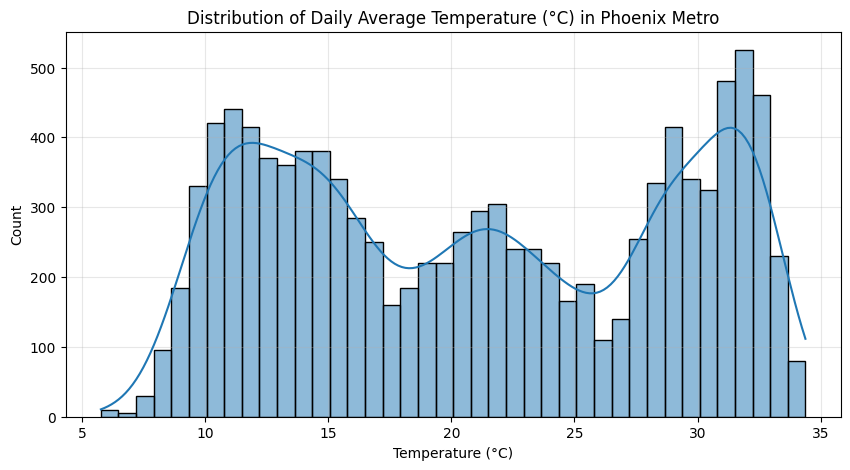

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(temps_az["avg_temp_c"], bins=40, kde=True)
plt.title("Distribution of Daily Average Temperature (°C) in Phoenix Metro")
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

#### 3.0.3 Monthly Mean Temperature Trends

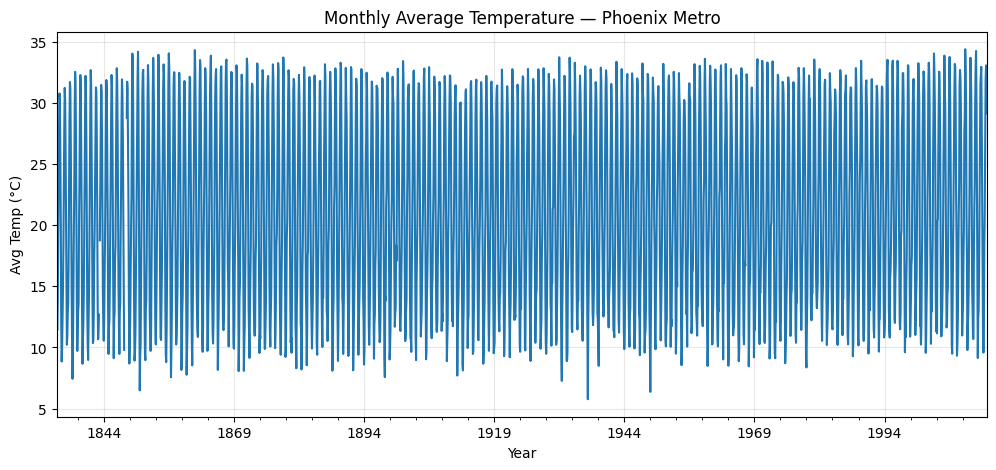

Hottest month: 2009-07-31 00:00:00 34.379
Coldest month: 1937-01-31 00:00:00 5.768000000000002


In [17]:
if "dt" in temps_az.columns:
    ts = temps_az.set_index("dt")["avg_temp_c"].resample("M").mean()

    plt.figure(figsize=(12,5))
    ts.plot()
    plt.title("Monthly Average Temperature — Phoenix Metro")
    plt.ylabel("Avg Temp (°C)")
    plt.xlabel("Year")
    plt.grid(alpha=0.3)
    plt.show()

    print("Hottest month:", ts.idxmax(), float(ts.max()))
    print("Coldest month:", ts.idxmin(), float(ts.min()))
else:
    print("No datetime column available for monthly trend plot.")

#### 3.0.4 Correlation Heatmap

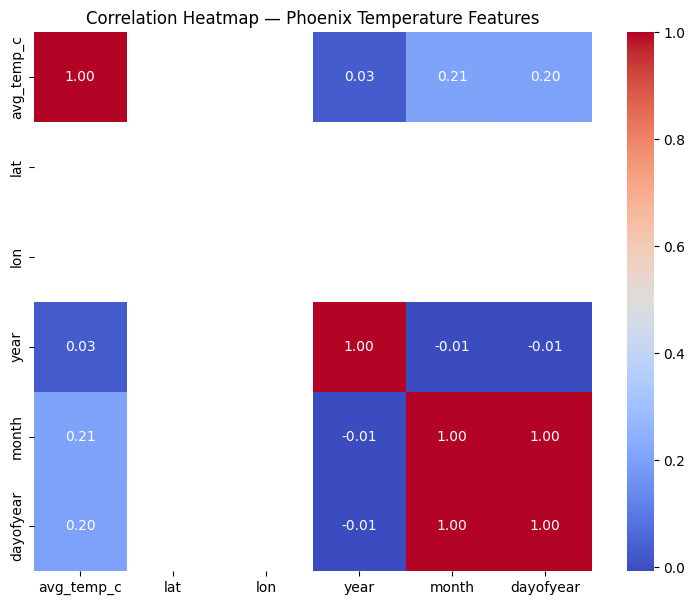

In [18]:
corr_df = temps_az.copy()

# Extract year/month/dayofyear first
if "dt" in corr_df.columns:
    corr_df["year"] = corr_df["dt"].dt.year
    corr_df["month"] = corr_df["dt"].dt.month
    corr_df["dayofyear"] = corr_df["dt"].dt.dayofyear

num_cols = ["avg_temp_c", "lat", "lon", "year", "month", "dayofyear"]
num_cols = [c for c in num_cols if c in corr_df.columns]

plt.figure(figsize=(9,7))
sns.heatmap(corr_df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap — Phoenix Temperature Features")
plt.show()

#### 3.0.5 Temperature vs. Latitude / Longitude

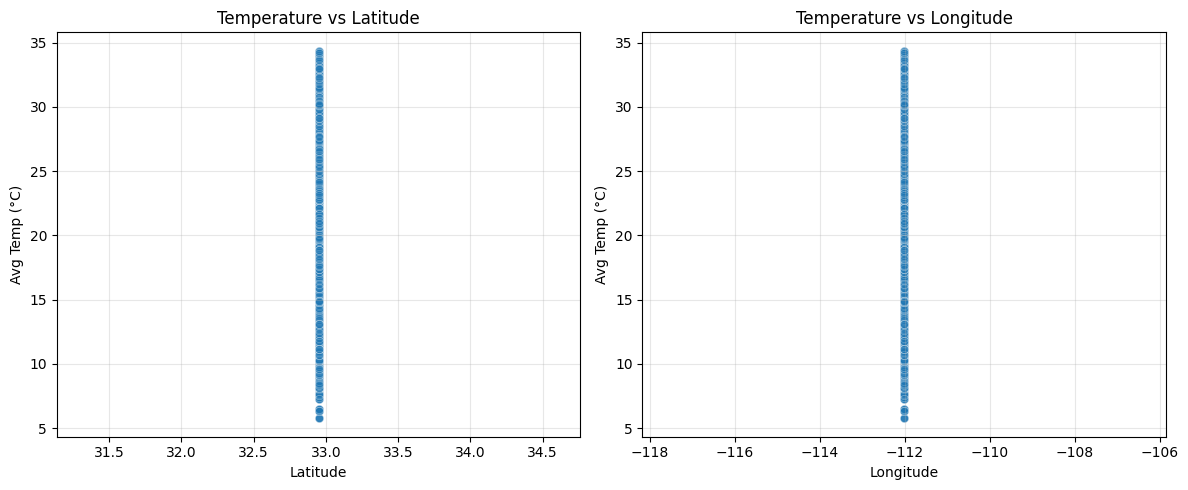

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(data=temps_az, x="lat", y="avg_temp_c", alpha=0.4)
plt.title("Temperature vs Latitude")
plt.xlabel("Latitude")
plt.ylabel("Avg Temp (°C)")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sns.scatterplot(data=temps_az, x="lon", y="avg_temp_c", alpha=0.4)
plt.title("Temperature vs Longitude")
plt.xlabel("Longitude")
plt.ylabel("Avg Temp (°C)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### 3.0.6 Temperature by City (comparison across Phoenix, Tempe, Mesa, etc.)

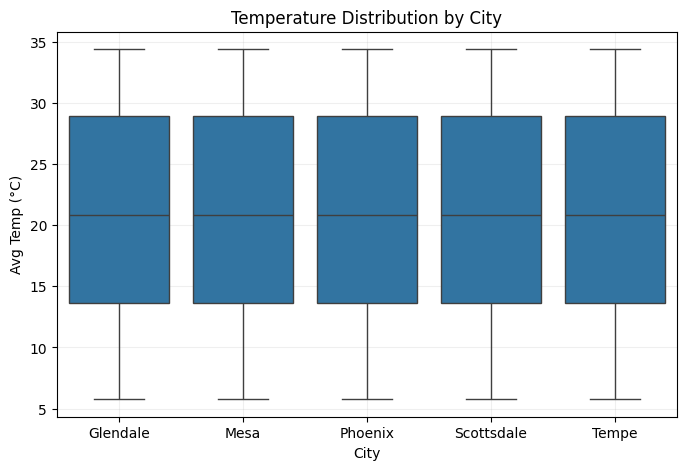

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(data=temps_az, x="city", y="avg_temp_c")
plt.title("Temperature Distribution by City")
plt.xlabel("City")
plt.ylabel("Avg Temp (°C)")
plt.grid(alpha=0.2)
plt.show()

### 3.1 Baseline Logistic Regression (Calendar + City + Coordinates)

In [21]:
# =============================================================
# 3.1 Baseline Logistic Regression
# Calendar + City + Coordinates (no shade features yet)
# =============================================================

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# -------------------------------------------------------------
# Prepare dataset
# -------------------------------------------------------------
base = temps_az.dropna(subset=["avg_temp_c"]).copy()

# Calendar features
if "dt" in base.columns:
    base["year"]      = base["dt"].dt.year
    base["month"]     = base["dt"].dt.month
    base["dayofyear"] = base["dt"].dt.dayofyear

# Model input columns
num_cols = ["year", "month", "dayofyear", "lat", "lon"]
num_cols = [c for c in num_cols if c in base.columns]

cat_cols = ["city", "country"]
cat_cols = [c for c in cat_cols if c in base.columns]

X_cols = num_cols + cat_cols

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)
print("Total X columns:", len(X_cols))

# -------------------------------------------------------------
# Preprocessing Pipeline
# -------------------------------------------------------------
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop",
)

clf = Pipeline(steps=[
    ("pre", pre),
    ("lr", LogisticRegression(
        max_iter=1500,
        solver="lbfgs",
        random_state=RANDOM_STATE
    ))
])

# -------------------------------------------------------------
# Cross-validation
# -------------------------------------------------------------
# FIX: KFold handles continuous split generation better here
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

accs, f1s, rocs = [], [], []
fold_info = []

print("\nRunning 5-fold CV for Baseline Logistic Regression...")

# KFold splits based on index, y is optional but we pass it for consistency
for k, (tr, te) in enumerate(cv.split(base[X_cols], base["avg_temp_c"] )):

    # Compute the "hot" threshold on TRAIN ONLY to avoid leakage
    thr = base.iloc[tr]["avg_temp_c"].quantile(0.70)

    # Create binary target: 1 if >= 70th percentile, else 0
    y_train = (base.iloc[tr]["avg_temp_c"] >= thr).astype(int)
    y_test  = (base.iloc[te]["avg_temp_c"] >= thr).astype(int)

    X_train = base.iloc[tr][X_cols]
    X_test  = base.iloc[te][X_cols]

    # Fit
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    try:
        roc = roc_auc_score(y_test, y_prob)
    except ValueError:
        roc = np.nan   # Edge case: a fold with only one class

    accs.append(acc)
    f1s.append(f1)
    rocs.append(roc)

    fold_info.append({
        "fold": k + 1,
        "threshold_C": float(thr),
        "acc": acc,
        "f1": f1,
        "roc_auc": roc,
        "train_pos_rate": float(y_train.mean()),
        "test_pos_rate": float(y_test.mean()),
        "n_train": len(tr),
        "n_test": len(te),
    })

# -------------------------------------------------------------
# Summary of results
# -------------------------------------------------------------
print("\n=== Baseline Logistic Regression Results (5-fold CV) ===")
print(f"Accuracy:  {np.nanmean(accs):.3f} ± {np.nanstd(accs):.3f}")
print(f"F1 Score:  {np.nanmean(f1s):.3f} ± {np.nanstd(f1s):.3f}")
print(f"ROC-AUC:   {np.nanmean(rocs):.3f} ± {np.nanstd(rocs):.3f}")

diag = pd.DataFrame(fold_info)
display(diag)

Numeric features: ['year', 'month', 'dayofyear', 'lat', 'lon']
Categorical features: ['city', 'country']
Total X columns: 7

Running 5-fold CV for Baseline Logistic Regression...

=== Baseline Logistic Regression Results (5-fold CV) ===
Accuracy:  0.700 ± 0.005
F1 Score:  0.000 ± 0.000
ROC-AUC:   0.607 ± 0.008


fold  threshold_C       acc   f1   roc_auc  train_pos_rate  test_pos_rate  n_train  n_test
0     1      27.8960  0.695185  0.0  0.602939        0.300140       0.304815     8556    2139
1     2      27.8960  0.695185  0.0  0.597169        0.300140       0.304815     8556    2139
2     3      27.9175  0.701730  0.0  0.615719        0.300023       0.298270     8556    2139
3     4      27.9240  0.702665  0.0  0.602501        0.300257       0.297335     8556    2139
4     5      27.9410  0.706872  0.0  0.617585        0.300140       0.293128     8556    2139

### 3.2 Baseline Regression Models (Predict °C Directly)

In [22]:
# =============================================================
# 3.2 Baseline Regression Models
# Predict avg_temp_c using calendar + lat/lon + city
# =============================================================

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

# Prepare dataset
reg = temps_az.dropna(subset=["avg_temp_c"]).copy()

# Calendar features
if "dt" in reg.columns:
    reg["year"]      = reg["dt"].dt.year
    reg["month"]     = reg["dt"].dt.month
    reg["dayofyear"] = reg["dt"].dt.dayofyear

num_cols = ["year", "month", "dayofyear", "lat", "lon"]
num_cols = [c for c in num_cols if c in reg.columns]

cat_cols = ["city", "country"]
cat_cols = [c for c in cat_cols if c in reg.columns]

X_cols = num_cols + cat_cols
X = reg[X_cols]
y = reg["avg_temp_c"]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200, min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, random_state=RANDOM_STATE)
}

# Scorers
def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer  = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer   = make_scorer(r2_score)

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []

print("\nRunning Baseline Regression Models...\n")

for name, model in models.items():
    pipe = Pipeline(steps=[("pre", pre), ("model", model)])

    rmse_scores = -cross_val_score(pipe, X, y, cv=kf, scoring=rmse_scorer)
    mae_scores  = -cross_val_score(pipe, X, y, cv=kf, scoring=mae_scorer)
    r2_scores   =  cross_val_score(pipe, X, y, cv=kf, scoring=r2_scorer)

    results.append({
        "model": name,
        "rmse_mean": rmse_scores.mean(),
        "rmse_std":  rmse_scores.std(),
        "mae_mean": mae_scores.mean(),
        "mae_std":  mae_scores.std(),
        "r2_mean":  r2_scores.mean(),
        "r2_std":   r2_scores.std(),
    })

results_df = pd.DataFrame(results)
display(results_df)


Numeric columns: ['year', 'month', 'dayofyear', 'lat', 'lon']
Categorical columns: ['city', 'country']

Running Baseline Regression Models...



model  rmse_mean  rmse_std  mae_mean   mae_std   r2_mean    r2_std
0  Linear Regression        NaN       NaN  5.997630  0.073831  0.197769  0.008859
1      Random Forest        NaN       NaN  0.304518  0.014279  0.996364  0.000506
2  Gradient Boosting        NaN       NaN  0.889937  0.011277  0.979311  0.000472

### Section 3.3 Feature Importance and Explainability

=== Top Logistic Regression Coefficients ===


feature    importance
1                   month  3.179046e+00
0                    year  5.203487e-02
4                     lon  0.000000e+00
3                     lat -1.593894e-15
9              city_Tempe -4.486412e-02
8         city_Scottsdale -4.486412e-02
7            city_Phoenix -4.486412e-02
5           city_Glendale -4.486412e-02
6               city_Mesa -4.486412e-02
10  country_United States -2.243206e-01
2               dayofyear -2.796549e+00

=== Top Random Forest Features ===


feature  importance
2               dayofyear    0.508130
1                   month    0.467231
0                    year    0.024432
6               city_Mesa    0.000043
8         city_Scottsdale    0.000042
5           city_Glendale    0.000042
7            city_Phoenix    0.000041
9              city_Tempe    0.000039
4                     lon    0.000000
3                     lat    0.000000
10  country_United States    0.000000

=== Top Gradient Boosting Features ===


feature  importance
1                   month    0.508256
2               dayofyear    0.486598
0                    year    0.005146
3                     lat    0.000000
4                     lon    0.000000
5           city_Glendale    0.000000
6               city_Mesa    0.000000
7            city_Phoenix    0.000000
8         city_Scottsdale    0.000000
9              city_Tempe    0.000000
10  country_United States    0.000000

=== Combined Feature Importance Table ===


feature  importance_rf  importance_gb  importance_lr
6               dayofyear       0.508130       0.486598  -2.796549e+00
9                   month       0.467231       0.508256   3.179046e+00
10                   year       0.024432       0.005146   5.203487e-02
1               city_Mesa       0.000043       0.000000  -4.486412e-02
3         city_Scottsdale       0.000042       0.000000  -4.486412e-02
0           city_Glendale       0.000042       0.000000  -4.486412e-02
2            city_Phoenix       0.000041       0.000000  -4.486412e-02
4              city_Tempe       0.000039       0.000000  -4.486412e-02
5   country_United States       0.000000       0.000000  -2.243206e-01
8                     lon       0.000000       0.000000   0.000000e+00
7                     lat       0.000000       0.000000  -1.593894e-15

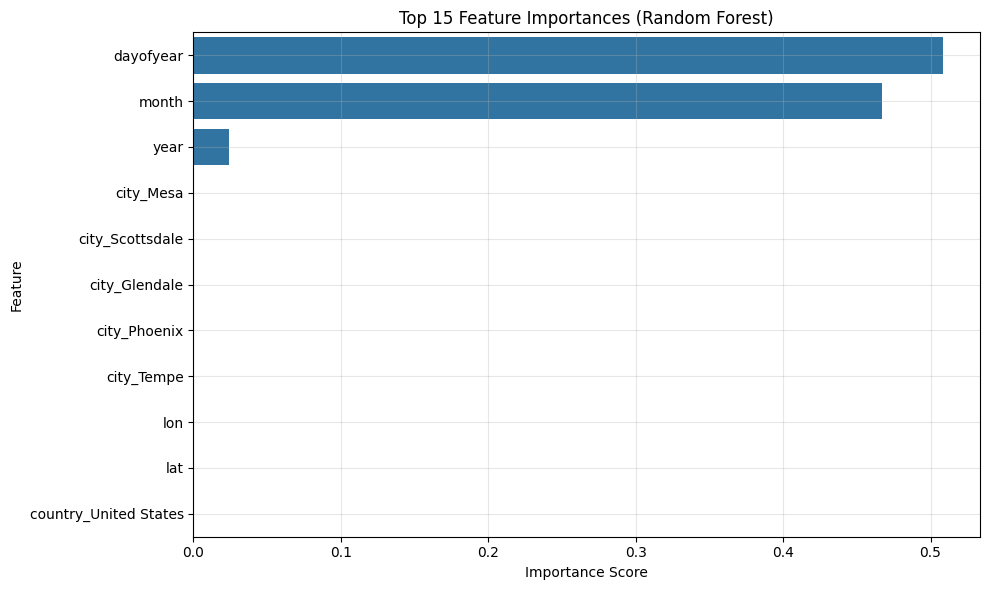

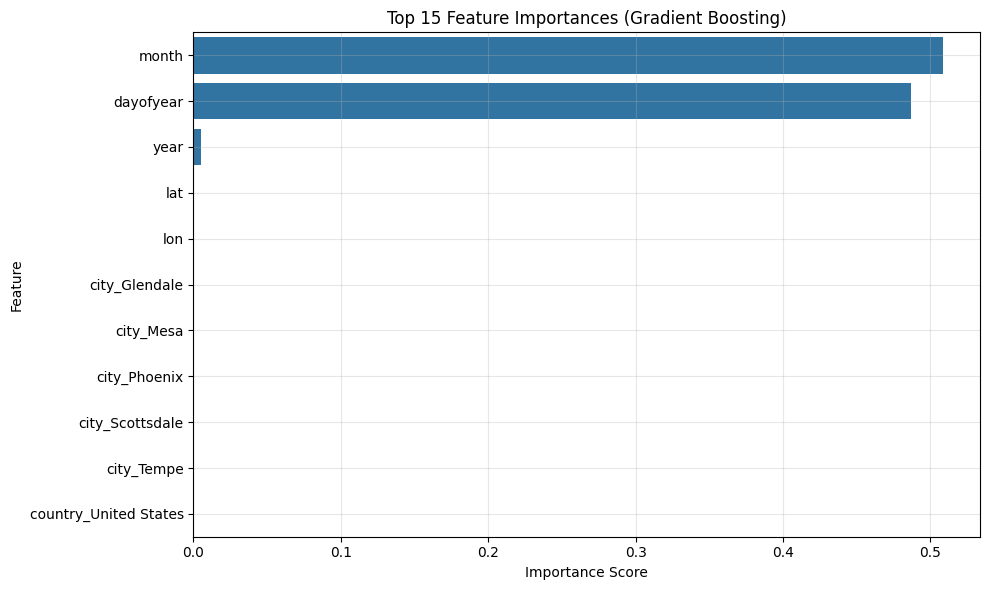

In [23]:
# =============================================================
# 3.3 Feature Importance and Explainability
# =============================================================

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# Prepare data
# -------------------------------------------------------------
reg = temps_az.dropna(subset=["avg_temp_c"]).copy()

if "dt" in reg.columns:
    reg["year"]      = reg["dt"].dt.year
    reg["month"]     = reg["dt"].dt.month
    reg["dayofyear"] = reg["dt"].dt.dayofyear

num_cols = ["year", "month", "dayofyear", "lat", "lon"]
num_cols = [c for c in num_cols if c in reg.columns]

cat_cols = ["city", "country"]
cat_cols = [c for c in cat_cols if c in reg.columns]

X_cols = num_cols + cat_cols
X = reg[X_cols]
y = reg["avg_temp_c"]

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

# Helper: extract feature names after preprocessing
def get_feature_names(preprocessor, num_cols, cat_cols, X):
    ohe = preprocessor.named_transformers_["cat"]
    cat_new_cols = list(ohe.get_feature_names_out(cat_cols))
    return num_cols + cat_new_cols


# =============================================================
# 3.3.1 Logistic Regression Coefficients
# =============================================================

log_reg = Pipeline([
    ("pre", pre),
    ("model", LogisticRegression(max_iter=1500, random_state=RANDOM_STATE))
])

log_reg.fit(X, (y >= y.quantile(0.70)).astype(int))

# Extract feature names
feature_names = get_feature_names(log_reg.named_steps["pre"], num_cols, cat_cols, X)
coeffs = log_reg.named_steps["model"].coef_.flatten()

lr_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": coeffs
}).sort_values("importance", ascending=False)

print("=== Top Logistic Regression Coefficients ===")
display(lr_importance.head(15))


# =============================================================
# 3.3.2 Random Forest Feature Importance
# =============================================================

rf = Pipeline([
    ("pre", pre),
    ("model", RandomForestRegressor(
        n_estimators=300,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf.fit(X, y)

rf_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.named_steps["model"].feature_importances_
}).sort_values("importance", ascending=False)

print("=== Top Random Forest Features ===")
display(rf_importance.head(15))


# =============================================================
# 3.3.3 Gradient Boosting Feature Importance
# =============================================================

gb = Pipeline([
    ("pre", pre),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=RANDOM_STATE
    ))
])

gb.fit(X, y)

gb_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": gb.named_steps["model"].feature_importances_
}).sort_values("importance", ascending=False)

print("=== Top Gradient Boosting Features ===")
display(gb_importance.head(15))


# =============================================================
# 3.3.4 Combined Importance Summary
# =============================================================

combined = (rf_importance
            .merge(gb_importance, on="feature", how="outer", suffixes=("_rf","_gb"))
            .merge(lr_importance, on="feature", how="outer"))

combined = combined.rename(columns={"importance": "importance_lr"})
combined = combined.fillna(0).sort_values("importance_rf", ascending=False)

print("=== Combined Feature Importance Table ===")
display(combined.head(20))


# =============================================================
# 3.3.5 Importance Plot (Random Forest)
# =============================================================

plt.figure(figsize=(10,6))
sns.barplot(data=rf_importance.head(15), x="importance", y="feature")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================
# 3.3.6 Importance Plot (Gradient Boosting)
# =============================================================

plt.figure(figsize=(10,6))
sns.barplot(data=gb_importance.head(15), x="importance", y="feature")
plt.title("Top 15 Feature Importances (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 3.4 Diagnostics and Error Analysis

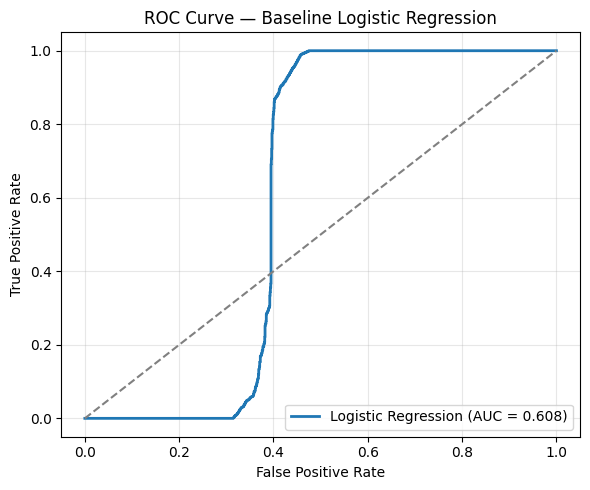

AUC: 0.6081238281339418


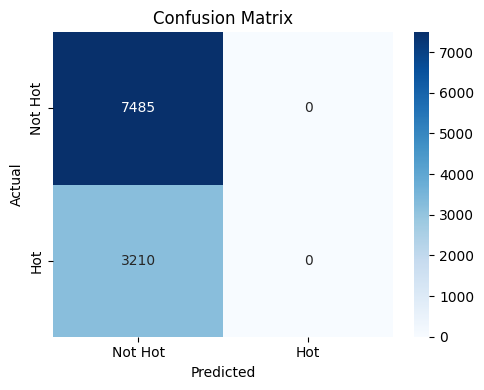

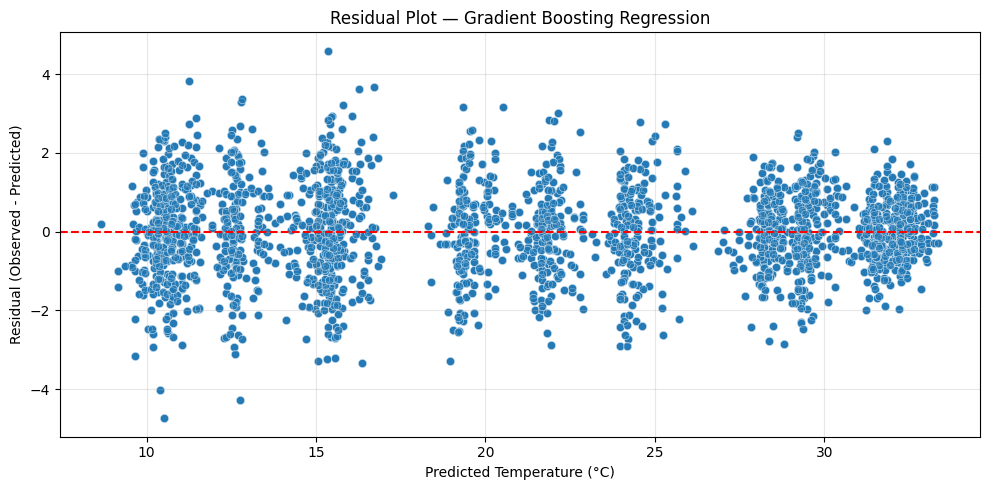

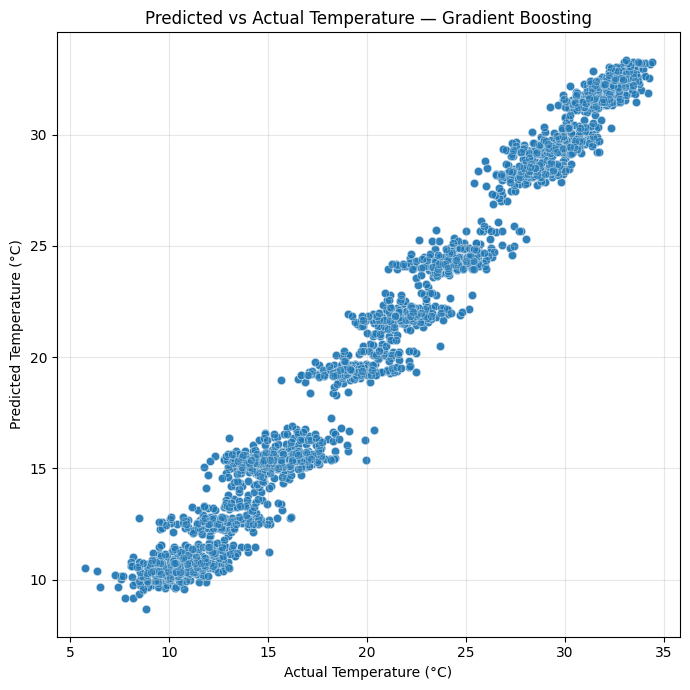

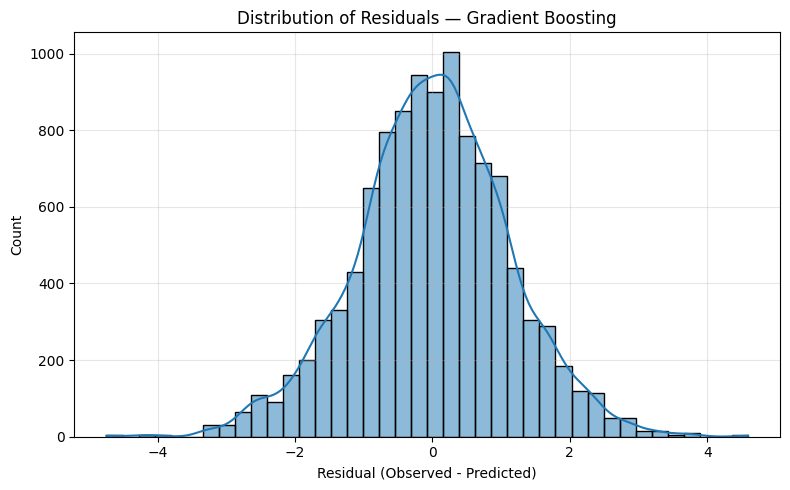

Residual Mean: 1.0090105469244059e-16
Residual Std: 1.1216008191358817


In [24]:
# =============================================================
# 3.4 Diagnostics and Error Analysis
# =============================================================

from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# Helpers
# -------------------------------------------------------------
def plot_confusion(cm, labels):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


# =============================================================
# 3.4.1 ROC Curve for Logistic Regression (from Section 3.1)
# =============================================================

# Refit the baseline model on full dataset for inspection
base = temps_az.dropna(subset=["avg_temp_c"]).copy()

if "dt" in base.columns:
    base["year"]      = base["dt"].dt.year
    base["month"]     = base["dt"].dt.month
    base["dayofyear"] = base["dt"].dt.dayofyear

num_cols = ["year", "month", "dayofyear", "lat", "lon"]
num_cols = [c for c in num_cols if c in base.columns]

cat_cols = ["city", "country"]
cat_cols = [c for c in cat_cols if c in base.columns]

X_cols = num_cols + cat_cols
X = base[X_cols]

# Logistic Regression threshold: use overall 70th percentile
thr = base["avg_temp_c"].quantile(0.70)
y = (base["avg_temp_c"] >= thr).astype(int)

# Fit
clf.fit(X, y)

# Predict probabilities
y_prob_full = clf.predict_proba(X)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y, y_prob_full)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Baseline Logistic Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("AUC:", roc_auc)


# =============================================================
# 3.4.2 Confusion Matrix (Logistic Regression)
# =============================================================

y_pred_full = clf.predict(X)
cm = confusion_matrix(y, y_pred_full)

plot_confusion(cm, labels=["Not Hot", "Hot"])


# =============================================================
# 3.4.3 Regression Diagnostics
# Fit Gradient Boosting Regression (best baseline regressor from 3.2)
# =============================================================

gb = Pipeline(steps=[
    ("pre", pre),
    ("model", GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, random_state=RANDOM_STATE
    ))
])

gb.fit(X, base["avg_temp_c"])
preds = gb.predict(X)

# ---------------- Residual Plot ----------------
residuals = base["avg_temp_c"] - preds

plt.figure(figsize=(10,5))
sns.scatterplot(x=preds, y=residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Temperature (°C)")
plt.ylabel("Residual (Observed - Predicted)")
plt.title("Residual Plot — Gradient Boosting Regression")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ---------------- Predicted vs Actual ----------------
plt.figure(figsize=(7,7))
sns.scatterplot(x=base["avg_temp_c"], y=preds, alpha=0.4)
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Predicted vs Actual Temperature — Gradient Boosting")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================
# 3.4.4 Error Distribution Histogram
# =============================================================

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Distribution of Residuals — Gradient Boosting")
plt.xlabel("Residual (Observed - Predicted)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Residual Mean:", residuals.mean())
print("Residual Std:", residuals.std())


# Section 4 -Feature Engineering & Master Table

In this section, I:
- Define the analysis unit
- Add IET microclimate information (dynamic features)
- Attach static land-cover and NDVI / terrain indicators (LC sensors)
- Attach static LULC-based temperature prediction features
- Attach tree / heat-health priority metrics
- Define regression and classification targets

### 4.0 Load Cleaned Intermediate Datasets

In [25]:
iet_path   = os.path.join(INTERIM_DIR, "iet_small.parquet")
temps_path = os.path.join(INTERIM_DIR, "kaggle_temps_az.parquet")
lc_path    = os.path.join(INTERIM_DIR, "lc_climate_clean.parquet")
lulc_path  = os.path.join(INTERIM_DIR, "lulc_clean.parquet")
tree_path  = os.path.join(INTERIM_DIR, "tree_heathealth_clean.parquet")

iet_small         = pd.read_parquet(iet_path)
temps_az         = pd.read_parquet(temps_path)
lc_climate_clean = pd.read_parquet(lc_path)
lulc_clean       = pd.read_parquet(lulc_path)
tree_df_clean    = pd.read_parquet(tree_path)

print("Loaded datasets:")
for name in ["iet_small", "temps_az", "lc_climate_clean", "lulc_clean", "tree_df_clean"]:
    print(name)


Loaded datasets:
iet_small
temps_az
lc_climate_clean
lulc_clean
tree_df_clean


### 4.1 Build City-Day Base Table (from Kaggle temps)

In [26]:
city_base = temps_az.copy()

if not np.issubdtype(city_base["dt"].dtype, np.datetime64):
    city_base["dt"] = pd.to_datetime(city_base["dt"])

city_base["year"] = city_base["dt"].dt.year
city_base["month"] = city_base["dt"].dt.month
city_base["day"] = city_base["dt"].dt.day
city_base["dayofyear"] = city_base["dt"].dt.dayofyear
city_base["dow"] = city_base["dt"].dt.dayofweek

group_cols = ["city", "country", "dt", "year", "month", "day", "dayofyear", "dow"]

cityday_base = (
    city_base
    .groupby(group_cols, as_index=False)
    .agg({"avg_temp_c": "mean", "lat": "mean", "lon": "mean"})
)

peek(cityday_base, "City-day base")


=== City-day base ===
Shape: (10695, 11)


city        country         dt  year  month  day  dayofyear  dow  avg_temp_c    lat     lon
9874       Tempe  United States 1945-05-01  1945      5    1        121    1      24.073  32.95 -112.02
3721        Mesa  United States 1967-05-01  1967      5    1        121    0      23.607  32.95 -112.02
7293  Scottsdale  United States 1908-07-01  1908      7    1        183    2      31.701  32.95 -112.02

city                  object
country               object
dt            datetime64[ns]
year                   int32
month                  int32
day                    int32
dayofyear              int32
dow                    int32
avg_temp_c           float64
lat                  float64
lon                  float64
dtype: object


### 4.2 Add IET Microclimate Features (weekday × time-of-day)

In [27]:
if "iet_small" not in globals():
    print("IET dataset not loaded; skip.")
    cityday_iet = None
else:
    df_i = iet_small.copy()

    cityday_iet = (
        df_i.groupby(["dow", "tod"])["temperature"]
            .mean()
            .unstack("tod")
            .rename(columns=lambda c: f"iet_temp_{c}")
            .reset_index()
    )

    cityday_env = cityday_base.merge(cityday_iet, on="dow", how="left")
    peek(cityday_iet, "IET feature table")



=== IET feature table ===
Shape: (7, 5)


tod  dow  iet_temp_afternoon  iet_temp_evening  iet_temp_morning  iet_temp_night
1      1           27.963517         27.232587         27.759565       26.623240
3      3           28.972580         27.570504         27.584562       26.268521
4      4           29.136725         27.538305         28.202955       26.679862

tod
dow                     int64
iet_temp_afternoon    float64
iet_temp_evening      float64
iet_temp_morning      float64
iet_temp_night        float64
dtype: object



### 4.3 Build LC + NDVI + Landcover Static Features



In [28]:
cityday_env = cityday_base.merge(cityday_iet, on="dow", how="left")
cityday_env["_key"] = 1

def summarize_static(df, prefix):
    num_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()

    if len(num_cols) == 0:
        print(f"[Warning] No numeric columns found in {prefix}")
        return pd.DataFrame({_key: [1]})

    summary = df[num_cols].mean().to_frame().T

    summary = summary.add_prefix(f"{prefix}_")

    summary["_key"] = 1
    return summary

lc_static   = summarize_static(lc_climate_clean, "lc")
lulc_static = summarize_static(lulc_clean,        "lulc")

#merge
cityday_env = (
    cityday_env
    .merge(lc_static,   on="_key", how="left")
    .merge(lulc_static, on="_key", how="left")
    .drop(columns=["_key"])
)

print("cityday_env:", cityday_env.shape)
peek(cityday_env, "Added LC + NDVI + Landcover")


cityday_env: (10695, 38)

=== Added LC + NDVI + Landcover ===
Shape: (10695, 38)


city        country         dt  year  month  day  dayofyear  dow  avg_temp_c    lat     lon  iet_temp_afternoon  iet_temp_evening  iet_temp_morning  iet_temp_night  \
6715  Scottsdale  United States 1860-05-01  1860      5    1        122    1      24.032  32.95 -112.02           27.963517         27.232587         27.759565       26.623240   
6813  Scottsdale  United States 1868-07-01  1868      7    1        183    2      32.517  32.95 -112.02           28.063691         27.019723         27.455663       26.254867   
2360        Mesa  United States 1853-12-01  1853     12    1        335    3      11.443  32.95 -112.02           28.972580         27.570504         27.584562       26.268521   

         lc_lat      lc_lon  lc_impervious_surface  lc_turf/grass  lc_tree_canopy  lc_buildings  lc_regional_air_temperature  lc_regional_relative_humidity  \
6715  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656   
6813  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656   
2360  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656   

      lc_regional_wind_speed  lc_mean_landsat_land_surface_temperature  lc_sensor_recorded_air_temperature   lulc_lat   lulc_lon  lulc_impervious  lulc_grass  lulc_tree  \
6715                6.188494                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703   
6813                6.188494                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703   
2360                6.188494                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703   

      lulc_building   lulc_lst  lulc_tair_pred25_75  lulc_tair_pred95  lulc_tair_pred25_75_nt  lulc_tair_pred95_nt  lulc_tair_diff_nt  
6715        0.14731  44.076652            35.303453         40.511569               24.960954            29.079424           4.118471  
6813        0.14731  44.076652            35.303453         40.511569               24.960954            29.079424           4.118471  
2360        0.14731  44.076652            35.303453         40.511569               24.960954            29.079424           4.118471

city                             object
country                          object
dt                       datetime64[ns]
year                              int32
month                             int32
day                               int32
dayofyear                         int32
dow                               int32
avg_temp_c                      float64
lat                             float64
lon                             float64
iet_temp_afternoon              float64
iet_temp_evening                float64
iet_temp_morning                float64
iet_temp_night                  float64
lc_lat                          float64
lc_lon                          float64
lc_impervious_surface           float64
lc_turf/grass                   float64
lc_tree_canopy                  float64
dtype: object


### 4.4 Build Tree Health Static Features

In [29]:
cityday_tree = cityday_env.copy()
cityday_tree["_key"] = 1

tree_static = summarize_static(tree_df_clean, "tree")

cityday_tree = (
    cityday_tree
    .merge(tree_static, on="_key", how="left")
    .drop(columns=["_key"])
)

print("cityday_tree:", cityday_tree.shape)
peek(cityday_tree, "Added Trees")


cityday_tree: (10695, 223)

=== Added Trees ===
Shape: (10695, 223)


city        country         dt  year  month  day  dayofyear  dow  avg_temp_c    lat     lon  iet_temp_afternoon  iet_temp_evening  iet_temp_morning  iet_temp_night  \
2071  Glendale  United States 2008-02-01  2008      2    1         32    4      12.239  32.95 -112.02           29.136725         27.538305         28.202955       26.679862   
5412   Phoenix  United States 1930-01-01  1930      1    1          1    2      10.147  32.95 -112.02           28.063691         27.019723         27.455663       26.254867   
626   Glendale  United States 1887-09-01  1887      9    1        244    3      28.644  32.95 -112.02           28.972580         27.570504         27.584562       26.268521   

         lc_lat      lc_lon  lc_impervious_surface  lc_turf/grass  lc_tree_canopy  lc_buildings  lc_regional_air_temperature  lc_regional_relative_humidity  \
2071  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656   
5412  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656   
626   35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656   

      lc_regional_wind_speed  lc_mean_landsat_land_surface_temperature  lc_sensor_recorded_air_temperature   lulc_lat   lulc_lon  lulc_impervious  lulc_grass  lulc_tree  \
2071                6.188494                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703   
5412                6.188494                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703   
626                 6.188494                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703   

      lulc_building   lulc_lst  lulc_tair_pred25_75  lulc_tair_pred95  lulc_tair_pred25_75_nt  lulc_tair_pred95_nt  lulc_tair_diff_nt  tree_objectid    tree_geoid    tree_aland  \
2071        0.14731  44.076652            35.303453         40.511569               24.960954            29.079424           4.118471        36123.5  2.794540e+10  1.059571e+08   
5412        0.14731  44.076652            35.303453         40.511569               24.960954            29.079424           4.118471        36123.5  2.794540e+10  1.059571e+08   
626         0.14731  44.076652            35.303453         40.511569               24.960954            29.079424           4.118471        36123.5  2.794540e+10  1.059571e+08   

       tree_awater  tree_b01001_001e  tree_b01001_calc_pctge65e  tree_b01001_calc_pctge65e_box_cox  tree_b03002_calc_pctnhwhitee  tree_pct_pop_minority  tree_b01001_003e  \
2071  2.715133e+06       4464.448703                  16.327632                           6.025263                      61.47714              38.445355         138.96577   
5412  2.715133e+06       4464.448703                  16.327632                           6.025263                      61.47714              38.445355         138.96577   
626   2.715133e+06       4464.448703                  16.327632                           6.025263                      61.47714              38.445355         138.96577   

      tree_b01001_027e  tree_total_young_people  tree_pct_young_people  tree_b17020_calc_pctpove  tree_b25002_calc_pctvace  tree_b15002_calc_pctlthse  tree_b08201_calc_pctnovehe  \
2071        132.683747               271.649517               5.935234                 14.617959                  11.82117                  12.681286                    9.218837   
5412        132.683747               271.649517               5.935234                 14.617959                  11.82117                  12.681286                    9.218837   
626         132.68

city                             object
country                          object
dt                       datetime64[ns]
year                              int32
month                             int32
day                               int32
dayofyear                         int32
dow                               int32
avg_temp_c                      float64
lat                             float64
lon                             float64
iet_temp_afternoon              float64
iet_temp_evening                float64
iet_temp_morning                float64
iet_temp_night                  float64
lc_lat                          float64
lc_lon                          float64
lc_impervious_surface           float64
lc_turf/grass                   float64
lc_tree_canopy                  float64
dtype: object


### 4.5 Build Regression / Classification Targets

In [30]:
cityday_targets = cityday_base.copy()

# regression target
cityday_targets["target_next_temp"] = (
    cityday_targets.groupby("city")["avg_temp_c"].shift(-1)
)

# classification target
thr = cityday_targets["avg_temp_c"].quantile(0.70)
cityday_targets["is_extreme"] = (cityday_targets["avg_temp_c"] >= thr).astype(int)

# keep only target columns
cityday_targets = cityday_targets[["city", "dt", "target_next_temp", "is_extreme"]]

peek(cityday_targets, "Targets")



=== Targets ===
Shape: (10695, 4)


city         dt  target_next_temp  is_extreme
9624        Tempe 1924-07-01            32.060           1
8147   Scottsdale 1979-09-01            22.922           1
10579       Tempe 2004-02-01            20.363           0

city                        object
dt                  datetime64[ns]
target_next_temp           float64
is_extreme                   int64
dtype: object


### 4.6 Final merge

In [31]:
master = cityday_tree.copy()

# merge target columns
master = master.merge(
    cityday_targets,
    on=["city", "dt"],
    how="left"
)

peek(master, "MASTER TABLE (with targets)")
print("Final master shape:", master.shape)

# save
master_path = os.path.join(INTERIM_DIR, "cityday_master.parquet")
master.to_parquet(master_path, index=False)
print("Saved to:", master_path)


=== MASTER TABLE (with targets) ===
Shape: (10695, 225)


city        country         dt  year  month  day  dayofyear  dow  avg_temp_c    lat     lon  iet_temp_afternoon  iet_temp_evening  iet_temp_morning  iet_temp_night  \
4746     Phoenix  United States 1874-07-01  1874      7    1        182    2      32.671  32.95 -112.02           28.063691         27.019723         27.455663       26.254867   
3621        Mesa  United States 1959-01-01  1959      1    1          1    3      12.098  32.95 -112.02           28.972580         27.570504         27.584562       26.268521   
7334  Scottsdale  United States 1911-12-01  1911     12    1        335    4       7.700  32.95 -112.02           29.136725         27.538305         28.202955       26.679862   

         lc_lat      lc_lon  lc_impervious_surface  lc_turf/grass  lc_tree_canopy  lc_buildings  lc_regional_air_temperature  lc_regional_relative_humidity  \
4746  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656   
3621  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656   
7334  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656   

      lc_regional_wind_speed  lc_mean_landsat_land_surface_temperature  lc_sensor_recorded_air_temperature   lulc_lat   lulc_lon  lulc_impervious  lulc_grass  lulc_tree  \
4746                6.188494                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703   
3621                6.188494                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703   
7334                6.188494                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703   

      lulc_building   lulc_lst  lulc_tair_pred25_75  lulc_tair_pred95  lulc_tair_pred25_75_nt  lulc_tair_pred95_nt  lulc_tair_diff_nt  tree_objectid    tree_geoid    tree_aland  \
4746        0.14731  44.076652            35.303453         40.511569               24.960954            29.079424           4.118471        36123.5  2.794540e+10  1.059571e+08   
3621        0.14731  44.076652            35.303453         40.511569               24.960954            29.079424           4.118471        36123.5  2.794540e+10  1.059571e+08   
7334        0.14731  44.076652            35.303453         40.511569               24.960954            29.079424           4.118471        36123.5  2.794540e+10  1.059571e+08   

       tree_awater  tree_b01001_001e  tree_b01001_calc_pctge65e  tree_b01001_calc_pctge65e_box_cox  tree_b03002_calc_pctnhwhitee  tree_pct_pop_minority  tree_b01001_003e  \
4746  2.715133e+06       4464.448703                  16.327632                           6.025263                      61.47714              38.445355         138.96577   
3621  2.715133e+06       4464.448703                  16.327632                           6.025263                      61.47714              38.445355         138.96577   
7334  2.715133e+06       4464.448703                  16.327632                           6.025263                      61.47714              38.445355         138.96577   

      tree_b01001_027e  tree_total_young_people  tree_pct_young_people  tree_b17020_calc_pctpove  tree_b25002_calc_pctvace  tree_b15002_calc_pctlthse  tree_b08201_calc_pctnovehe  \
4746        132.683747               271.649517               5.935234                 14.617959                  11.82117                  12.681286                    9.218837   
3621        132.683747               271.649517               5.935234                 14.617959                  11.82117                  12.681286                    9.218837   
7334        

city                             object
country                          object
dt                       datetime64[ns]
year                              int32
month                             int32
day                               int32
dayofyear                         int32
dow                               int32
avg_temp_c                      float64
lat                             float64
lon                             float64
iet_temp_afternoon              float64
iet_temp_evening                float64
iet_temp_morning                float64
iet_temp_night                  float64
lc_lat                          float64
lc_lon                          float64
lc_impervious_surface           float64
lc_turf/grass                   float64
lc_tree_canopy                  float64
dtype: object
Final master shape: (10695, 225)
Saved to: /content/drive/MyDrive/CSE475 - Final Project/interim/cityday_master.parquet


In [32]:
print("\n================ MASTER COLUMNS ================\n")
for c in master.columns:
    print(c)
print("\n===============================================\n")
print("Total columns:", len(master.columns))


================ MASTER COLUMNS ================

city
country
dt
year
month
day
dayofyear
dow
avg_temp_c
lat
lon
iet_temp_afternoon
iet_temp_evening
iet_temp_morning
iet_temp_night
lc_lat
lc_lon
lc_impervious_surface
lc_turf/grass
lc_tree_canopy
lc_buildings
lc_regional_air_temperature
lc_regional_relative_humidity
lc_regional_wind_speed
lc_mean_landsat_land_surface_temperature
lc_sensor_recorded_air_temperature
lulc_lat
lulc_lon
lulc_impervious
lulc_grass
lulc_tree
lulc_building
lulc_lst
lulc_tair_pred25_75
lulc_tair_pred95
lulc_tair_pred25_75_nt
lulc_tair_pred95_nt
lulc_tair_diff_nt
tree_objectid
tree_geoid
tree_aland
tree_awater
tree_b01001_001e
tree_b01001_calc_pctge65e
tree_b01001_calc_pctge65e_box_cox
tree_b03002_calc_pctnhwhitee
tree_pct_pop_minority
tree_b01001_003e
tree_b01001_027e
tree_total_young_people
tree_pct_young_people
tree_b17020_calc_pctpove
tree_b25002_calc_pctvace
tree_b15002_calc_pctlthse
tree_b08201_calc_pctnovehe
tree_b08201_calc_pctnovehe_box_cox
tree_b28002_

# Section 5 – City-Day Modeling on Master Table (Person C)

In this section we train and evaluate machine learning models using the
final **city-day master feature table** built in Section 4:

- Regression target: `target_next_temp` (next-day average temperature by city-day)
- Classification target: `is_extreme` (top 30% hottest city-days)
- Models:
  - Logistic Regression (classification baseline)
  - Random Forest & Gradient Boosting (regression)
  - Optional: Random Forest & Gradient Boosting (classification)
- Outputs:
  - Metrics tables (R², RMSE, MAE, Accuracy, F1, ROC-AUC)
  - Confusion matrix for classification
  - Feature-importance bar charts (RF & GBM)
  - Cross-validation scores and simple hyperparameter tuning

5.0 Load master table and define features / targets

In [33]:
import os
import numpy as np
import pandas as pd

# Reload master if it does not exist in memory
if "master" not in globals():
    master_path = os.path.join(INTERIM_DIR, "cityday_master.parquet")
    print("Reloading master from:", master_path)
    master = pd.read_parquet(master_path)

print("Master shape:", master.shape)

# Keep only rows where targets exist
model_df = master.dropna(subset=["target_next_temp", "is_extreme"]).copy()
print("After dropping rows with missing targets:", model_df.shape)

# Targets
target_reg = "target_next_temp"
target_clf = "is_extreme"

# Columns that should NOT be used as ML features
exclude_cols = ["city", "dt", target_reg, target_clf]

# Candidate feature columns
candidate_cols = [c for c in model_df.columns if c not in exclude_cols]

# Keep only numeric features (avoid strings such as 'United States')
numeric_feature_cols = [
    c for c in candidate_cols
    if np.issubdtype(model_df[c].dtype, np.number)
]

# Report which columns were excluded because they were not numeric
dropped = set(candidate_cols) - set(numeric_feature_cols)
print("Dropped non-numeric columns:", dropped)

# Final feature list
feature_cols = numeric_feature_cols

# Feature and target matrices
X = model_df[feature_cols]
y_reg = model_df[target_reg]
y_clf = model_df[target_clf]

print("Number of numeric features:", len(feature_cols))
print("Sample features:", feature_cols[:10])

Master shape: (10695, 225)
After dropping rows with missing targets: (10690, 225)
Dropped non-numeric columns: {'country'}
Number of numeric features: 220
Sample features: ['year', 'month', 'day', 'dayofyear', 'dow', 'avg_temp_c', 'lat', 'lon', 'iet_temp_afternoon', 'iet_temp_evening']


5.1 Train / Test split

In [34]:
from sklearn.model_selection import train_test_split

Xtr_reg, Xte_reg, ytr_reg, yte_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

Xtr_clf, Xte_clf, ytr_clf, yte_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf
)

print("Regression train/test:", Xtr_reg.shape, Xte_reg.shape)
print("Classification train/test:", Xtr_clf.shape, Xte_clf.shape)

Regression train/test: (8552, 220) (2138, 220)
Classification train/test: (8552, 220) (2138, 220)


5.2 Helper functions for metrics / tables

In [35]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
import pandas as pd

def regression_metrics(y_true, y_pred):
    """
    Return RMSE, MAE, and R^2 in a dict.
    We do NOT use the 'squared' argument to avoid conflicts with
    any custom mean_squared_error functions defined earlier.
    """
    mse = mean_squared_error(y_true, y_pred)   # may be sklearn or custom
    rmse = np.sqrt(mse)
    return {
        "RMSE": rmse,
        "MAE":  mean_absolute_error(y_true, y_pred),
        "R2":   r2_score(y_true, y_pred),
    }

def classification_metrics(y_true, y_pred, y_proba=None):
    """Return Accuracy, F1, and ROC-AUC (if probabilities available)."""
    out = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1":       f1_score(y_true, y_pred),
    }
    if y_proba is not None:
        out["ROC_AUC"] = roc_auc_score(y_true, y_proba)
    return out

def show_results_table(results_dict, title):
    """results_dict: {model_name: {metric: value}}"""
    print(title)
    df_res = pd.DataFrame(results_dict).T
    display(df_res.round(4))

5.3 Logistic Regression baseline (classification)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

log_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

log_clf.fit(Xtr_clf, ytr_clf)
y_pred_log = log_clf.predict(Xte_clf)
y_proba_log = log_clf.predict_proba(Xte_clf)[:, 1]

log_results = classification_metrics(yte_clf, y_pred_log, y_proba_log)
show_results_table({"Logistic Regression": log_results},
                   "Classification metrics – Logistic Regression baseline")

Classification metrics – Logistic Regression baseline


Accuracy      F1  ROC_AUC
Logistic Regression    0.9953  0.9923      1.0

5.3.1 Confusion matrix for Logistic Regression

Saved confusion matrix to: /content/drive/MyDrive/CSE475 - Final Project/reports_figures/cityday_conf_matrix_logreg.png


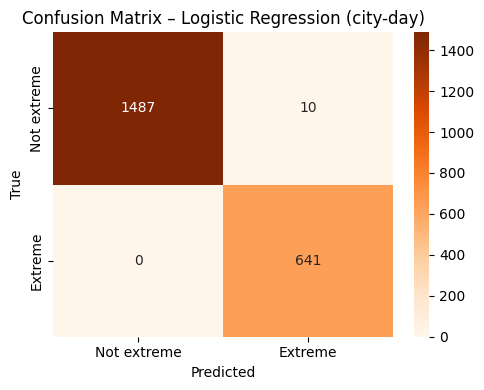

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(yte_clf, y_pred_log)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Not extreme", "Extreme"],
            yticklabels=["Not extreme", "Extreme"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Logistic Regression (city-day)")
plt.tight_layout()

fig_path = os.path.join(REPORTS_DIR, "cityday_conf_matrix_logreg.png")
plt.savefig(fig_path, dpi=300)
print("Saved confusion matrix to:", fig_path)
plt.show()

5.4 Random Forest & Gradient Boosting – Regression

In [38]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf_reg = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_reg.fit(Xtr_reg, ytr_reg)
y_pred_rf = rf_reg.predict(Xte_reg)

gb_reg = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE
)
gb_reg.fit(Xtr_reg, ytr_reg)
y_pred_gb = gb_reg.predict(Xte_reg)

reg_results = {
    "Random Forest (reg)": regression_metrics(yte_reg, y_pred_rf),
    "Gradient Boosting (reg)": regression_metrics(yte_reg, y_pred_gb),
}
show_results_table(reg_results, "Regression metrics – city-day master table")

Regression metrics – city-day master table


RMSE     MAE      R2
Random Forest (reg)      0.2274  0.0827  0.9992
Gradient Boosting (reg)  1.1083  0.8608  0.9808

5.5 Random Forest & Gradient Boosting – Classification

In [39]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_clf.fit(Xtr_clf, ytr_clf)
y_pred_rf_clf = rf_clf.predict(Xte_clf)
y_proba_rf_clf = rf_clf.predict_proba(Xte_clf)[:, 1]

gb_clf = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE
)
gb_clf.fit(Xtr_clf, ytr_clf)
y_pred_gb_clf = gb_clf.predict(Xte_clf)
y_proba_gb_clf = gb_clf.predict_proba(Xte_clf)[:, 1]

clf_results = {
    "Logistic Regression":  log_results,
    "Random Forest (clf)":  classification_metrics(yte_clf, y_pred_rf_clf, y_proba_rf_clf),
    "Gradient Boosting (clf)": classification_metrics(yte_clf, y_pred_gb_clf, y_proba_gb_clf),
}
show_results_table(clf_results, "Classification metrics – model comparison (city-day)")

Classification metrics – model comparison (city-day)


Accuracy      F1  ROC_AUC
Logistic Regression        0.9953  0.9923      1.0
Random Forest (clf)        1.0000  1.0000      1.0
Gradient Boosting (clf)    1.0000  1.0000      1.0

5.6 Feature importance – Random Forest & Gradient Boosting

Saved RF feature importance to: /content/drive/MyDrive/CSE475 - Final Project/reports_figures/cityday_feature_importance_rf_reg.png


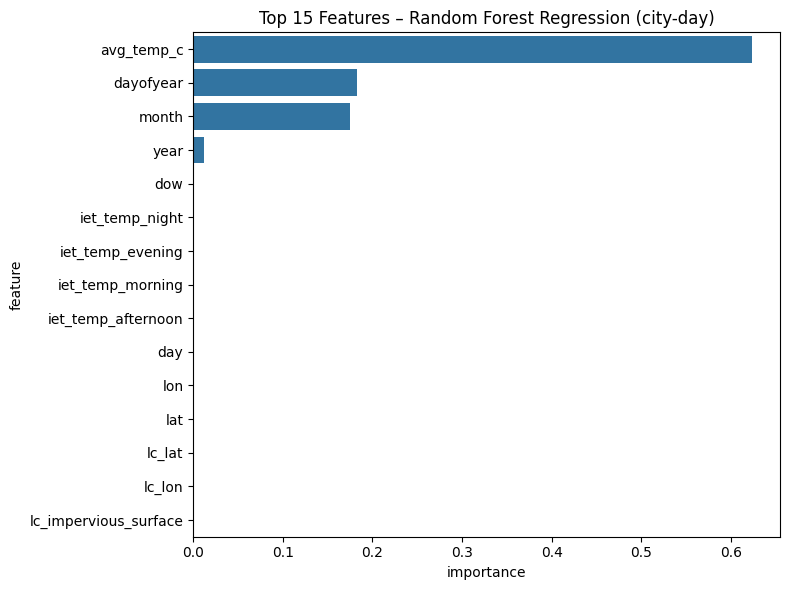

Saved GBM feature importance to: /content/drive/MyDrive/CSE475 - Final Project/reports_figures/cityday_feature_importance_gb_reg.png


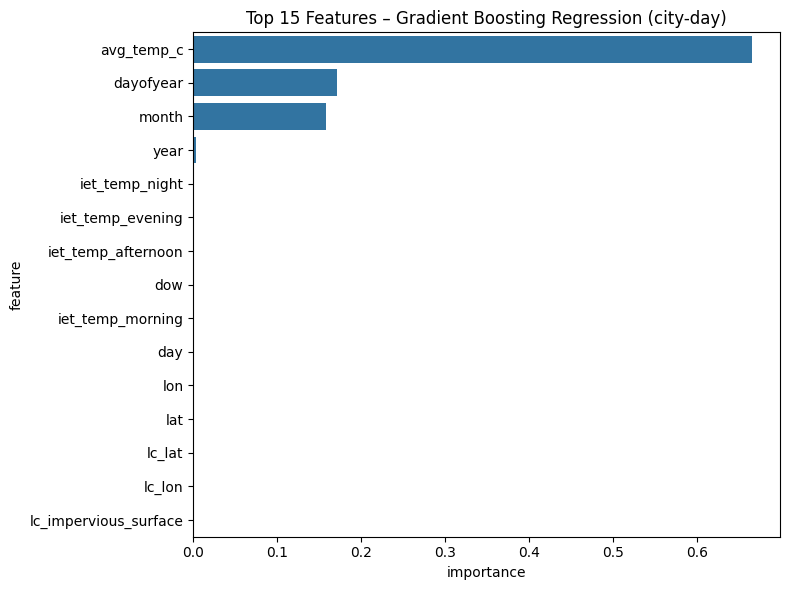

In [40]:
feature_names = feature_cols

# Random Forest importance
rf_importances = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": rf_reg.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8,6))
sns.barplot(data=rf_importances.head(15), x="importance", y="feature")
plt.title("Top 15 Features – Random Forest Regression (city-day)")
plt.tight_layout()
rf_path = os.path.join(REPORTS_DIR, "cityday_feature_importance_rf_reg.png")
plt.savefig(rf_path, dpi=300)
print("Saved RF feature importance to:", rf_path)
plt.show()

# Gradient Boosting importance
gb_importances = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": gb_reg.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8,6))
sns.barplot(data=gb_importances.head(15), x="importance", y="feature")
plt.title("Top 15 Features – Gradient Boosting Regression (city-day)")
plt.tight_layout()
gb_path = os.path.join(REPORTS_DIR, "cityday_feature_importance_gb_reg.png")
plt.savefig(gb_path, dpi=300)
print("Saved GBM feature importance to:", gb_path)
plt.show()

5.7 Cross-validation for key models

In [41]:
from sklearn.model_selection import cross_val_score

# Logistic Regression – ROC-AUC
cv_log = cross_val_score(
    log_clf, X, y_clf,
    cv=5, scoring="roc_auc", n_jobs=-1
)
print("Logistic Regression CV ROC-AUC: ",
      cv_log.mean(), "+/-", cv_log.std())

# Random Forest Regression – R²
cv_rf_reg = cross_val_score(
    rf_reg, X, y_reg,
    cv=5, scoring="r2", n_jobs=-1
)
print("Random Forest Regression CV R²:",
      cv_rf_reg.mean(), "+/-", cv_rf_reg.std())

Logistic Regression CV ROC-AUC:  0.9999739468536657 +/- 0.0
Random Forest Regression CV R²: 0.9999867325828454 +/- 0.0


5.8 Simple hyperparameter tuning for RF regression

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
}

rf_reg_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

grid = GridSearchCV(
    rf_reg_base,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X, y_reg)

print("Best parameters:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

Best parameters: {'max_depth': None, 'n_estimators': 400}
Best CV R²: 0.9999254978351767


5.9  Time-Series Cross-Validation (Regression)

In [43]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import numpy as np

# Use only the date columns that actually exist in master
date_cols = [c for c in ["year", "month", "day"] if c in master.columns]

# Build column list for TS-CV and remove duplicates while preserving order
ts_cols_base = date_cols + feature_cols + [target_reg]
ts_cols = list(dict.fromkeys(ts_cols_base))  # removes duplicates like 'year'

# Subset the master table
df_ts = master[ts_cols].copy()

# Drop any rows that contain NaNs in features or target
df_ts = df_ts.dropna(subset=feature_cols + [target_reg])
print("TS-CV data shape after dropping NaNs:", df_ts.shape)

# Sort chronologically to respect the time dimension
if date_cols:
    df_ts = df_ts.sort_values(by=date_cols)

X_ts = df_ts[feature_cols].values
y_ts = df_ts[target_reg].values

tscv = TimeSeriesSplit(n_splits=5)

fold_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_ts), start=1):
    X_train, X_test = X_ts[train_idx], X_ts[test_idx]
    y_train, y_test = y_ts[train_idx], y_ts[test_idx]

    # Extra safety: skip degenerate folds with no variation in y_test
    if len(np.unique(y_test)) < 2:
        print(f"Fold {fold} skipped (not enough variation in y_test).")
        continue

    model = RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    fold_scores.append(score)
    print(f"Fold {fold} R^2: {score:.4f}")

if fold_scores:
    print("TS-CV mean R^2:", np.mean(fold_scores))
    print("TS-CV std:",  np.std(fold_scores))
else:
    print("TS-CV could not be computed: no valid folds.")

TS-CV data shape after dropping NaNs: (10690, 221)
Fold 1 R^2: 0.9671
Fold 2 R^2: 0.9553
Fold 3 R^2: 0.9619
Fold 4 R^2: 0.9498
Fold 5 R^2: 0.9532
TS-CV mean R^2: 0.9574782454878015
TS-CV std: 0.006221201963833789


5.10  Sensitivity Test – Remove avg_temp_c (Regression)

In [44]:
# Remove the dominant feature
features_wo_avg = [c for c in feature_cols if c != "avg_temp_c"]

X_reg_wo = master[features_wo_avg]
y_reg_wo = master[target_reg]

# Drop rows that contain NaN in X or y
valid_rows = ~(X_reg_wo.isna().any(axis=1) | y_reg_wo.isna())
X_reg_wo = X_reg_wo[valid_rows]
y_reg_wo = y_reg_wo[valid_rows]

print("Shape after removing avg_temp_c and dropping NaNs:", X_reg_wo.shape)

# Train/test split
Xtr_wo, Xte_wo, ytr_wo, yte_wo = train_test_split(
    X_reg_wo, y_reg_wo,
    test_size=0.2,
    random_state=42
)

# Train RF
rf_wo = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_wo.fit(Xtr_wo, ytr_wo)
y_pred_wo = rf_wo.predict(Xte_wo)

# Evaluate
reg_metrics_wo = regression_metrics(yte_wo, y_pred_wo)

print("Regression WITHOUT avg_temp_c")
display(reg_metrics_wo)

Shape after removing avg_temp_c and dropping NaNs: (10690, 219)
Regression WITHOUT avg_temp_c


{'RMSE': np.float64(0.22351837130831007),
 'MAE': 0.0857272419706845,
 'R2': 0.9992170390273349}

Section 6: Unsupervised Learning & Spatial Analysis (Person D)
---



In [45]:
# =============================================================
# 6.0 Inspect Master Table (Before Clustering)
# =============================================================

import pandas as pd
import numpy as np

master_path = os.path.join(INTERIM_DIR, "cityday_master.parquet")
master = pd.read_parquet(master_path)

print("Master shape:", master.shape)
print("Columns:", len(master.columns))
display(master.head(9))


Master shape: (10695, 225)
Columns: 225


city        country         dt  year  month  day  dayofyear  dow  avg_temp_c    lat     lon  iet_temp_afternoon  iet_temp_evening  iet_temp_morning  iet_temp_night  \
0  Glendale  United States 1835-01-01  1835      1    1          1    3      11.544  32.95 -112.02           28.972580         27.570504         27.584562       26.268521   
1  Glendale  United States 1835-02-01  1835      2    1         32    6      11.412  32.95 -112.02           29.015337         27.539759         28.185808       26.316606   
2  Glendale  United States 1835-03-01  1835      3    1         60    6      14.308  32.95 -112.02           29.015337         27.539759         28.185808       26.316606   
3  Glendale  United States 1835-04-01  1835      4    1         91    2      18.443  32.95 -112.02           28.063691         27.019723         27.455663       26.254867   
4  Glendale  United States 1835-05-01  1835      5    1        121    4      23.092  32.95 -112.02           29.136725         27.538305         28.202955       26.679862   
5  Glendale  United States 1835-06-01  1835      6    1        152    0      28.196  32.95 -112.02           29.401596         27.737227         28.250542       26.421991   
6  Glendale  United States 1835-07-01  1835      7    1        182    2      30.765  32.95 -112.02           28.063691         27.019723         27.455663       26.254867   
7  Glendale  United States 1835-08-01  1835      8    1        213    5      29.996  32.95 -112.02           28.592135         27.267843         28.033002       26.413402   
8  Glendale  United States 1835-09-01  1835      9    1        244    1      25.747  32.95 -112.02           27.963517         27.232587         27.759565       26.623240   

      lc_lat      lc_lon  lc_impervious_surface  lc_turf/grass  lc_tree_canopy  lc_buildings  lc_regional_air_temperature  lc_regional_relative_humidity  lc_regional_wind_speed  \
0  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656                6.188494   
1  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656                6.188494   
2  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656                6.188494   
3  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656                6.188494   
4  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656                6.188494   
5  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656                6.188494   
6  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656                6.188494   
7  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656                6.188494   
8  35.864791 -106.395428               0.409189       0.152595        0.220703      0.127266                    27.685279                      51.338656                6.188494   

   lc_mean_landsat_land_surface_temperature  lc_sensor_recorded_air_temperature   lulc_lat   lulc_lon  lulc_impervious  lulc_grass  lulc_tree  lulc_building   lulc_lst  \
0                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0.088546   0.125703        0.14731  44.076652   
1                                 42.677985                           28.595354  36.141225 -109.24079         0.364227    0

In [46]:
# =============================================================
# 6.0Filter by year: Only retain data for modern cities (after 2000).
# =============================================================

if "master" in globals():
    master_filtered = master.copy()
else:
    master_path = os.path.join(INTERIM_DIR, "cityday_master.parquet")
    master_filtered = pd.read_parquet(master_path)


master_filtered["dt"] = pd.to_datetime(master_filtered["dt"], errors="coerce")
master_filtered["year"] = master_filtered["dt"].dt.year


master_filtered = master_filtered[ master_filtered["year"] >= 2000 ].copy()

print("After year filtering (>=2000):", master_filtered.shape)
print("Cities included:", master_filtered["city"].unique())


if "cluster_df" in globals() and "year" in cluster_df.columns:
    df_map = cluster_df[ cluster_df["year"] >= 2000 ].copy()
else:
    df_map = master_filtered.copy()



After year filtering (>=2000): (825, 225)
Cities included: ['Glendale' 'Mesa' 'Phoenix' 'Scottsdale' 'Tempe']


In [47]:
# =============================================================
# 6.1 Select Numeric Features for Clustering
# =============================================================

numeric_cols = [c for c in master.columns if np.issubdtype(master[c].dtype, np.number)]

# Remove constant column
constant_cols = [c for c in numeric_cols if master[c].nunique() <= 1]

# Remove meaningless columns
remove_cols = ["lat", "lon", "lc_lat", "lc_lon", "year"]
remove_cols += [c for c in numeric_cols if ("geoid" in c.lower()) or c.endswith("_id")]

drop_cols = set(constant_cols + remove_cols)

cluster_cols = [c for c in numeric_cols if c not in drop_cols]

print("Original numeric:", len(numeric_cols))
print("Removed:", drop_cols)
print("Final cluster features:", len(cluster_cols))


Original numeric: 222
Removed: {'lc_buildings', 'tree_flood_buddy_index_cnty_rank', 'tree_in_flood_egress_index_st_pctl', 'tree_flood_buddy_index_nat_pctl', 'tree_vul_pop_index_nat_quan', 'tree_cooling_center_index_nat_pctl', 'tree_reduce_imp_surf_index_cnty_rank', 'tree_trees_index_cnty_pctl', 'tree_b01001_027e', 'tree_trees_index_st_rank', 'tree_b25002_calc_pcttotalrente', 'tree_vul_pop_index_cnty_rank', 'lulc_tree', 'tree_intervention_score', 'tree_pct_hh_lives_alone', 'tree_spart_index_cnty_rank', 'tree_heat_buddy_index', 'tree_spart_index_cnty_pctl', 'tree_in_flood_aware_index_cnty_rank', 'lc_lat', 'tree_mean_annual_est_pm2_5_μg_m3', 'lon', 'lulc_tair_diff_nt', 'tree_cnt_rd_inter_per_sqkm_box_cox', 'tree_trees_index_nat_pctl', 'tree_restore_builtup_index_nat_pctl', 'tree_pct_area_restore', 'tree_pres_open_space_index_cnty_rank', 'tree_air_filtration_index', 'tree_in_flood_aware_index_nat_pctl', 'tree_reduce_imp_surf_index', 'tree_air_filtration_index_st_pctl', 'tree_in_flood_aware

Original row number: 10695
Number of rows used for clustering (without missing rows): 10690
k=2, silhouette=0.2267
k=3, silhouette=0.3000
k=4, silhouette=0.2999
k=5, silhouette=0.3348
k=6, silhouette=0.3117
k=7, silhouette=0.3442
k=8, silhouette=0.3285


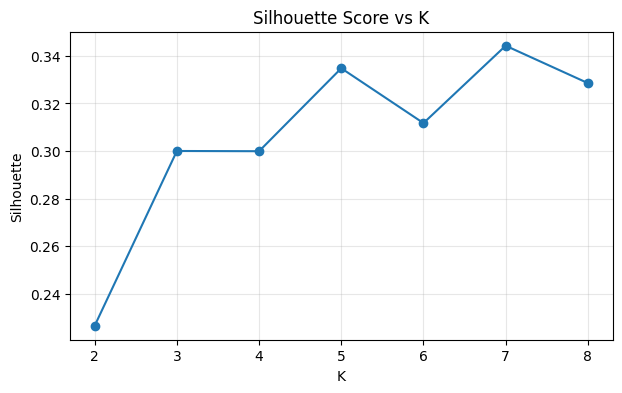

Best k = 7


In [48]:
# =============================
# 6.2 KMeans + Silhouette
# =============================
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# First, only take numerical features
df_cluster_full = master[cluster_cols]

#Record rows with absolutely no missing values.
valid_idx = df_cluster_full.dropna().index
df_cluster = df_cluster_full.loc[valid_idx]

print("Original row number:", master.shape[0])
print("Number of rows used for clustering (without missing rows):", df_cluster.shape[0])

# standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Silhouette
sil_scores = []
k_range = range(2, 9)

for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f"k={k}, silhouette={sil:.4f}")

plt.figure(figsize=(7,4))
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.grid(alpha=0.3)
plt.show()

best_k = k_range[np.argmax(sil_scores)]
print("Best k =", best_k)

# Refit using the optimal k
kmeans_final = KMeans(n_clusters=best_k, n_init=10, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Create a new cluster column in the master module: first set all of them to NaN.
master["cluster"] = np.nan
# Only fill in the labels for the lines in valid_idx.
master.loc[valid_idx, "cluster"] = cluster_labels


Explained variance ratio: [0.2632559  0.25893066]


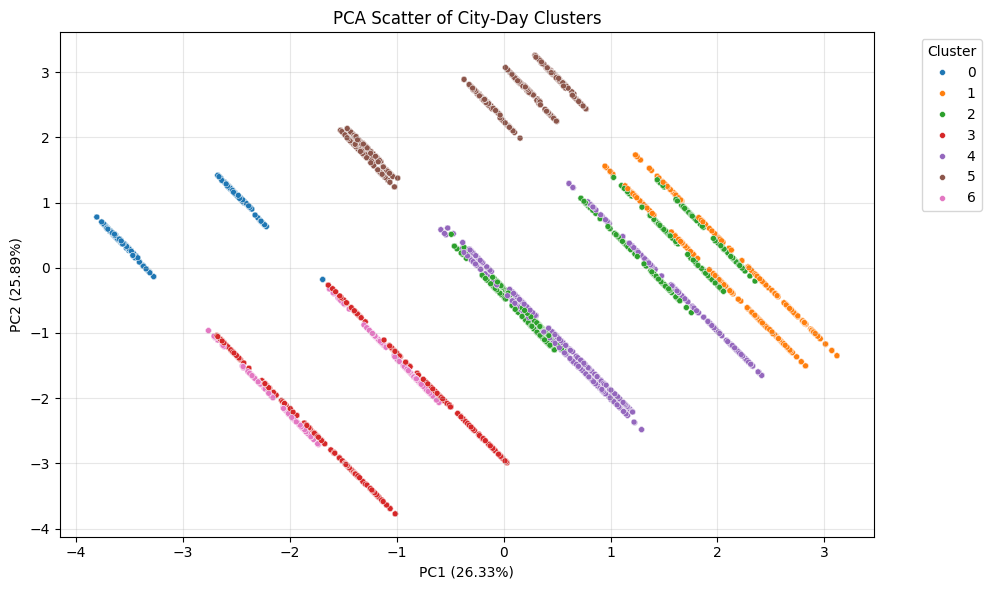

In [49]:
# =============================================================
# 6.3 PCA Scatter Plot of City-Day Clusters
# =============================================================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Only take the labels that participated in the clustering.
cluster_labels = master.loc[valid_idx, "cluster"].astype(int).values

# PCA reduces the standardized features to 2 dimensions.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)   # X_scaled comes from 6.2

print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=cluster_labels,
    palette="tab10",
    s=18
)
plt.title("PCA Scatter of City-Day Clusters")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
plt.grid(alpha=0.3)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.savefig(os.path.join(REPORTS_DIR, "pca_clusters.png"), dpi=300)
plt.show()



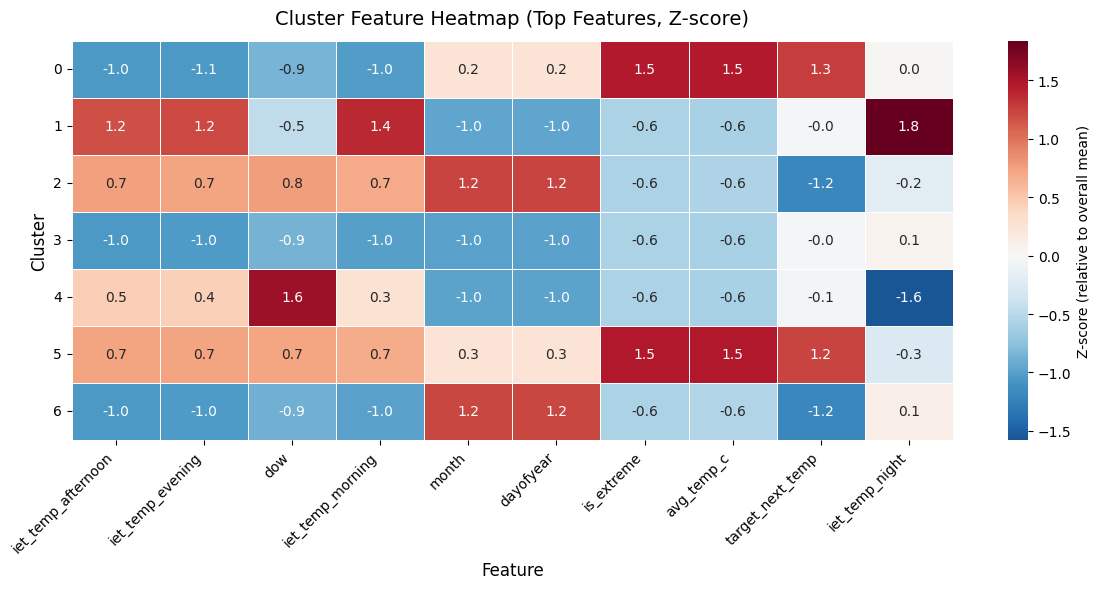

In [50]:
# =============================================================
# 6.4(a) Prettier Cluster Feature Heatmap
# =============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Use only the rows with the cluster tag.
master_valid = master.dropna(subset=["cluster"]).copy()
master_valid["cluster"] = master_valid["cluster"].astype(int)

# Eigenmean of each cluster
cluster_means = master_valid.groupby("cluster")[cluster_cols].mean()

# z-score
cluster_means_z = (cluster_means - cluster_means.mean()) / cluster_means.std()

# 1)First, calculate "which features differ most between the clusters".
feature_importance = cluster_means_z.abs().mean(axis=0).sort_values(ascending=False)
topN = 12   # If you want more, change it to 15 or 20.
top_features = feature_importance.head(topN).index

cm = cluster_means_z[top_features]

cm.columns = [c.replace("_index_nat_quan", "") for c in cm.columns]
cm.columns = [c.replace("_pct_", "%_") for c in cm.columns]

plt.figure(figsize=(1.0*topN, 6))  # Width is linked to the number of features, making it look more symmetrical.
sns.heatmap(
    cm,
    cmap="RdBu_r",
    center=0,
    annot=True,             # Write the numbers in the grid.
    fmt=".1f",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Z-score (relative to overall mean)"}
)

plt.title("Cluster Feature Heatmap (Top Features, Z-score)", fontsize=14, pad=12)
plt.ylabel("Cluster", fontsize=12)
plt.xlabel("Feature", fontsize=12)

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, "cluster_feature_heatmap_pretty.png"), dpi=300)
plt.show()



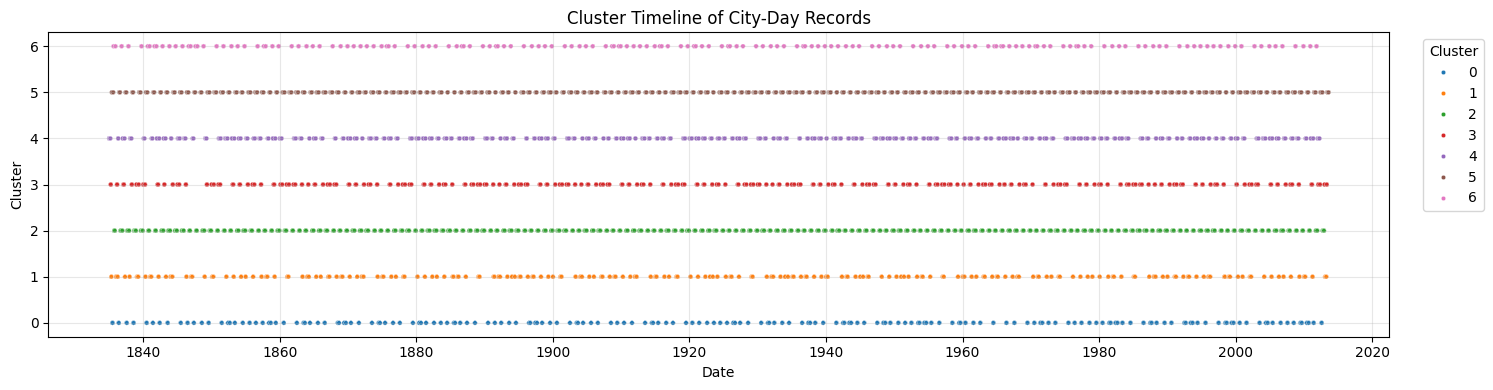

In [51]:
# =============================================================
# 6.4(b) Cluster Timeline Over Date
# =============================================================

plt.figure(figsize=(15, 4))
sns.scatterplot(
    data=master_valid,
    x="dt",
    y="cluster",
    hue="cluster",
    palette="tab10",
    s=10
)
plt.title("Cluster Timeline of City-Day Records")
plt.xlabel("Date")
plt.ylabel("Cluster")
plt.grid(alpha=0.3)
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

plt.savefig(os.path.join(REPORTS_DIR, "cluster_timeline.png"), dpi=300)
plt.show()


In [53]:
# Initialize df_map_city from df_map, which is available from previous cells
df_map_city = df_map.copy()

print("df_map_city dt range:", df_map_city["dt"].min(), "=>", df_map_city["dt"].max())
if "year" in df_map_city.columns:
    print("df_map_city year range:", df_map_city["year"].min(), "=>", df_map_city["year"].max())
else:
    print("df_map_city no year list")

df_map_city dt range: 2000-01-01 00:00:00 => 2013-09-01 00:00:00
df_map_city year range: 2000 => 2013


In [54]:
# =============================================================
# 6.5 Interactive Map A – City-Day Cluster / Temperature Summary
# =============================================================
!pip -q install folium branca

import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import numpy as np
import pandas as pd
import os

# ---------- 0) From the previous steps, we obtained... df_map ----------
df_map_city = df_map.copy()

print("df_map_city dt range:", df_map_city["dt"].min(), "=>", df_map_city["dt"].max())
if "year" in df_map_city.columns:
    print("df_map_city year range:", df_map_city["year"].min(), "=>", df_map_city["year"].max())
else:
    print("df_map_city 没有 year 列")


if "cluster" not in df_map_city.columns:
    df_map_city["cluster"] = 0


df_map_city = df_map_city.dropna(subset=["lat", "lon"]).copy()

# ---------- 1)Aggregate by city / lat / lon and calculate statistics.----------
city_summary = (
    df_map_city
    .groupby(["city", "lat", "lon"], as_index=False)
    .agg(
        n_days        = ("dt", "count"),
        avg_temp      = ("avg_temp_c", "mean"),
        extreme_rate  = ("is_extreme", "mean"),
        median_cluster= ("cluster", "median"),
    )
)

print(" city_summary（lat/lon (Not yet corrected):")
display(city_summary[["city", "lat", "lon"]])

# ---------- 2) Manually specify the actual coordinates of 5 cities ----------

manual_coords = {
    "Glendale":   (33.5386, -112.1850),
    "Phoenix":    (33.4484, -112.0740),
    "Mesa":       (33.4152, -111.8315),
    "Scottsdale": (33.4942, -111.9261),
    "Tempe":      (33.4255, -111.9400),
}

# Create new columns `plot_lat` and `plot_lon`: use manual coordinates first, then fall back to the original `lat`/`lon` coordinates for other cities.
city_summary["plot_lat"] = city_summary["city"].map(lambda c: manual_coords.get(c, (np.nan, np.nan))[0])
city_summary["plot_lon"] = city_summary["city"].map(lambda c: manual_coords.get(c, (np.nan, np.nan))[1])

mask = city_summary["plot_lat"].isna()
city_summary.loc[mask, "plot_lat"] = city_summary.loc[mask, "lat"]
city_summary.loc[mask, "plot_lon"] = city_summary.loc[mask, "lon"]

print("Revised city_summary：")
display(city_summary[["city", "lat", "lon", "plot_lat", "plot_lon"]])

# ---------- 3) Use the corrected plot_lat / plot_lon to draw Folium maps.----------
center_lat = city_summary["plot_lat"].mean()
center_lon = city_summary["plot_lon"].mean()

m_city = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles="CartoDB positron"
)

vmin = city_summary["avg_temp"].min()
vmax = city_summary["avg_temp"].max()
cmap = cm.LinearColormap(
    colors=["blue", "yellow", "red"],
    vmin=vmin,
    vmax=vmax,
    caption="Mean daily temperature (°C)"
)

marker_cluster = MarkerCluster().add_to(m_city)

for _, row in city_summary.iterrows():
    color = cmap(row["avg_temp"])
    popup_html = f"""
    <b>{row['city']}</b><br>
    Days in dataset: {int(row['n_days'])}<br>
    Mean temp: {row['avg_temp']:.1f} °C<br>
    Extreme-day fraction: {row['extreme_rate']:.2f}<br>
    Median cluster: {int(row['median_cluster'])}
    """
    folium.CircleMarker(
        location=[row["plot_lat"], row["plot_lon"]],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.85,
        popup=folium.Popup(popup_html, max_width=260),
    ).add_to(marker_cluster)

cmap.add_to(m_city)

# ---------- 4) Save + Show ----------
map_city_path = os.path.join(REPORTS_DIR, "map_cityday_clusters.html")
m_city.save(map_city_path)
print("✅ Saved interactive city-day map to:", map_city_path)

from IPython.display import HTML
HTML(m_city._repr_html_())



df_map_city dt range: 2000-01-01 00:00:00 => 2013-09-01 00:00:00
df_map_city year range: 2000 => 2013
 city_summary（lat/lon (Not yet corrected):


city    lat     lon
0    Glendale  32.95 -112.02
1        Mesa  32.95 -112.02
2     Phoenix  32.95 -112.02
3  Scottsdale  32.95 -112.02
4       Tempe  32.95 -112.02

Revised city_summary：


city    lat     lon  plot_lat  plot_lon
0    Glendale  32.95 -112.02   33.5386 -112.1850
1        Mesa  32.95 -112.02   33.4152 -111.8315
2     Phoenix  32.95 -112.02   33.4484 -112.0740
3  Scottsdale  32.95 -112.02   33.4942 -111.9261
4       Tempe  32.95 -112.02   33.4255 -111.9400

✅ Saved interactive city-day map to: /content/drive/MyDrive/CSE475 - Final Project/reports_figures/map_cityday_clusters.html


In [55]:
# =============================================================
# 6.5 AZ LULC Priority Points Map (using LULC_temp_prediction)
# =============================================================
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import numpy as np
import pandas as pd
import os

# 1) Ensure Lulc is already loaded

# If Lulc already exists, there's no need to load it again.
if "lulc" not in globals():
    lulc_path = os.path.join(RAW_DIR, "LULC_temp_prediction.csv")
    print("Reloading LULC from:", lulc_path)
    lulc = pd.read_csv(lulc_path)

print("LULC shape:", lulc.shape)

# 2)First, convert lat/lon to a numerical value (as a precaution).
lulc["lat"] = pd.to_numeric(lulc["lat"], errors="coerce")
lulc["lon"] = pd.to_numeric(lulc["lon"], errors="coerce")

# 3) Filter points within the AZ range by latitude and longitude (rough bounding box)
az_lulc = lulc[
    lulc["lat"].between(31, 37) &    # Arizona approximate latitude
    lulc["lon"].between(-115, -109)  # Arizona approximate longitude
].copy()

print("AZ subset shape:", az_lulc.shape)
print("AZ cities:", az_lulc["city"].value_counts().head())

if az_lulc.empty:
    print("⚠ The absence of points within the AZ area suggests that this LULC dataset may only include other cities such as Baltimore.。")
else:
    # 4)Construct a "priority index"

    for col in ["tree", "impervious", "building"]:
        if col not in az_lulc.columns:
            print(f"List {col} If it's not in LULC, please change it to the actual column name in your data.。")
    az_lulc["priority"] = (
        0.5 * (1 - az_lulc["tree"]) +     # Fewer trees → higher score
        0.3 * az_lulc["impervious"] +     #Hard paving is more common → High score
        0.2 * az_lulc["building"]         # More buildings → higher score
    )

    # 5) To prevent map lag, a maximum of 2000 points will be sampled.
    max_points = 2000
    if len(az_lulc) > max_points:
        az_lulc = az_lulc.sample(max_points, random_state=RANDOM_STATE)
        print(f"Sampled {max_points} AZ points for mapping.")
    else:
        print(f"Using all {len(az_lulc)} AZ points for mapping.")

    # 6) Create a Folium map
    center_lat = az_lulc["lat"].mean()
    center_lon = az_lulc["lon"].mean()

    m_az = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=10,
        tiles="CartoDB positron"
    )

    # Color range (using quantiles to prevent extreme values)
    vmin = az_lulc["priority"].quantile(0.05)
    vmax = az_lulc["priority"].quantile(0.95)

    cmap = cm.LinearColormap(
        colors=["green", "yellow", "red"],
        vmin=vmin,
        vmax=vmax,
        caption="Tree-planting priority (low → high)"
    )

    marker_cluster = MarkerCluster().add_to(m_az)

    val_min = az_lulc["priority"].min()
    val_max = az_lulc["priority"].max()
    denom = (val_max - val_min) if (val_max - val_min) != 0 else 1.0

    for _, row in az_lulc.iterrows():
        v = row["priority"]
        color = cmap(v)
        radius = 4 + 6 * (v - val_min) / denom  # Radius 4~10

        popup_html = f"""
        <b>{row.get('city', 'Unknown city')}</b><br>
        Priority score: {v:.2f}<br>
        Tree cover: {row['tree']:.2f}<br>
        Impervious: {row['impervious']:.2f}<br>
        (lat, lon) = ({row['lat']:.4f}, {row['lon']:.4f})
        """

        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=float(radius),
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.8,
            popup=folium.Popup(popup_html, max_width=260),
        ).add_to(marker_cluster)

    cmap.add_to(m_az)

    # 7) Save + Show
    map_az_path = os.path.join(REPORTS_DIR, "map_lulc_priority_az_points.html")
    m_az.save(map_az_path)
    print("Saved AZ LULC priority map to:", map_az_path)

    m_az
from IPython.display import HTML

HTML(m_az._repr_html_())


LULC shape: (693932, 14)
AZ subset shape: (251462, 14)
AZ cities: city
Phoenix    147190
Tucson     104272
Name: count, dtype: int64
Sampled 2000 AZ points for mapping.
Saved AZ LULC priority map to: /content/drive/MyDrive/CSE475 - Final Project/reports_figures/map_lulc_priority_az_points.html
